<a href="https://colab.research.google.com/github/joze-Lee/leetcode_solutions/blob/main/Copy_of_Group_19_CN7031.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Big Data Analytics [CN7031] CRWK 2024-25**
# **Group ID: 19**

---





# **Initiate and Configure Spark**

---


In [ ]:
!pip3 install pyspark

In [ ]:
# linking with Spark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("CN7031_group_19") \
    .master("local[2]") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.sql.shuffle.partitions", "10") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "2") \
    .config("spark.dynamicAllocation.maxExecutors", "10") \
    .getOrCreate()

# To check the configuration
executor_memory = spark.conf.get("spark.executor.memory")
executor_cores = spark.conf.get("spark.executor.cores")
shuffle_partitions = spark.conf.get("spark.sql.shuffle.partitions")
print("Executor Memory: ", executor_memory)
print("Executor Cores: ", executor_cores)
print("Shuffle Partitions: ", shuffle_partitions)


Executor Memory:  8g
Executor Cores:  4
Shuffle Partitions:  10


# **Load Unstructured Data**

---


In [ ]:
# Loading data:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/MyDrive/web.log" "/content/"
!ls /content/

Mounted at /content/drive
drive  sample_data  web.log



# **Task 1: Data Processing using PySpark DF [40 marks]**

---



In [ ]:
# Task 1
# - query 1
from pyspark.sql import functions as F
from pyspark.sql.functions import regexp_extract
from pyspark.sql.window import Window


file_path ="/content/web.log"



level1_log_pattern = r'(\S+) - - \[([^\]]+)] "(.*?) (.*?) (.*?)" (\d+) (\d+)'

# Read the log file and parse necessary columns directly
level2_parsed_df = spark.read.text(file_path) \
    .withColumn("IP", regexp_extract("value", level1_log_pattern, 1)) \
    .withColumn("Timestamp", regexp_extract("value", level1_log_pattern, 2)) \
    .withColumn("Endpoint", regexp_extract("value", level1_log_pattern, 4)) \
    .withColumn("Protocol", regexp_extract("value", level1_log_pattern, 5)) \
    .withColumn("Status", regexp_extract("value", level1_log_pattern, 6).cast("int")) \
    .withColumn("Bytes", regexp_extract("value", level1_log_pattern, 7).cast("int")) \
    .withColumn("Timestamp", F.to_timestamp(F.col("Timestamp"), "dd/MMM/yyyy:HH:mm:ss")) \
    .select("IP", "Timestamp", "Endpoint", "Protocol", "Status", "Bytes")


# level2_parsed_df = level2_parsed_df.withColumn("epoch_seconds", F.unix_timestamp("Timestamp"))
# level2_parsed_df.show(truncate=False)

# Define the session timeout in seconds (e.g., 30 minutes = 1800 seconds)
session_timeout = 1800

# Calculate the time difference between consecutive requests for the same IP
window_spec = Window.partitionBy("IP").orderBy("Timestamp")

# Calculate the previous timestamp using lag
level2_parsed_df = level2_parsed_df.withColumn("previous_timestamp", F.lag("Timestamp", 1).over(window_spec))

# Calculate the time difference in seconds between the current and previous request
level2_parsed_df = level2_parsed_df.withColumn(
    "time_diff",
    F.unix_timestamp("Timestamp") - F.unix_timestamp("previous_timestamp")
)

# Assign session ID based on the time difference
level2_parsed_df = level2_parsed_df.withColumn(
    "session_start",
    F.when(F.col("time_diff") > session_timeout, 1).otherwise(0)
)

# Assign a session ID based on the session start flag
level2_parsed_df = level2_parsed_df.withColumn(
    "session_id",
    F.sum("session_start").over(window_spec.rowsBetween(Window.unboundedPreceding, 0))
)

session_count_df = level2_parsed_df.groupBy("IP", "session_id").count()

# Count the total number of sessions per IP
session_count_per_ip_df = session_count_df.groupBy("IP").agg(F.count("session_id").alias("session_count"))

# Sort the result by session count in descending order
sorted_session_count_df = session_count_per_ip_df.orderBy(F.col("session_count").desc())

# Show the results
sorted_session_count_df.show(truncate=False)



+---------------+-------------+
|IP             |session_count|
+---------------+-------------+
|1.194.139.212  |2            |
|10.175.188.46  |2            |
|1.21.213.107   |2            |
|147.199.153.168|2            |
|11.22.14.168   |2            |
|100.148.50.184 |2            |
|107.133.194.107|2            |
|102.127.8.212  |2            |
|1.57.49.51     |2            |
|103.51.19.1    |2            |
|1.228.160.169  |2            |
|104.152.89.90  |2            |
|10.132.166.254 |2            |
|108.211.16.59  |2            |
|1.4.140.204    |2            |
|110.212.188.185|2            |
|100.193.247.206|2            |
|112.149.201.145|2            |
|10.45.78.214   |2            |
|114.237.203.188|2            |
+---------------+-------------+
only showing top 20 rows



<ipython-input-5-95d4ab836ea1>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


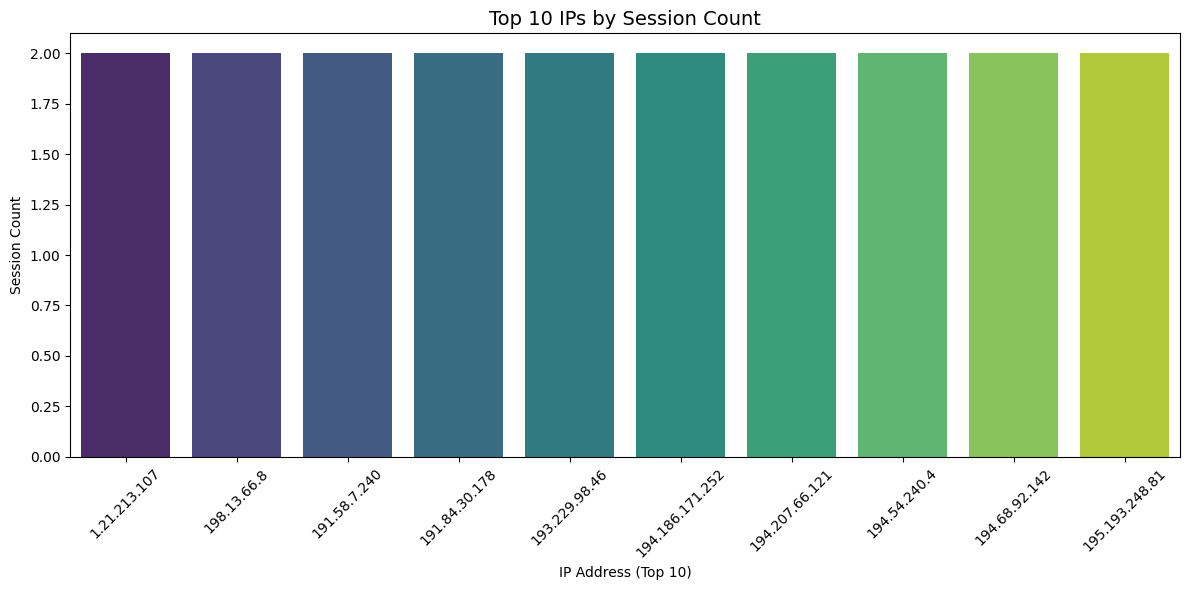

In [ ]:
# query 1 graph
import matplotlib.pyplot as plot
import pandas as pd
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame
session_count_pd = sorted_session_count_df.toPandas()

# Sort values for better visualization
session_count_pd.sort_values(by="session_count", ascending=False, inplace=True)

# Step 1: Focus on the top 10 IPs with the highest session counts
top_n = 10  # Adjust this number as needed
top_ips = session_count_pd.head(top_n)

# Step 2: Plot using Seaborn barplot
plot.figure(figsize=(12, 6))
sns.barplot(
    data=top_ips,
    x="IP",
    y="session_count",
    palette="viridis"
)

# Add labels and title
plot.xlabel('IP Address (Top 10)', fontsize=10)
plot.ylabel('Session Count', fontsize=10)
plot.title('Top 10 IPs by Session Count', fontsize=14)
plot.xticks(rotation=45, fontsize=10)

# Show the plot
plot.tight_layout()
plot.show()



In [ ]:
# Query 2
traffic_per_hour_df = level2_parsed_df \
    .withColumn("visit_date", F.to_date("Timestamp")) \
    .withColumn("hour_of_day", F.hour("Timestamp")) \
    .groupBy("IP", "visit_date", "hour_of_day","Endpoint") \
    .agg(
        F.count("*").alias("request_count"),
        F.sum("Bytes").alias("total_response_size")
    )

# 2. Unique visitors per day
unique_visitors_df = level2_parsed_df \
    .withColumn("visit_date", F.to_date("Timestamp")) \
    .groupBy("visit_date") \
    .agg(F.countDistinct("IP").alias("unique_visitors_count"))
# 3. Response size statistics by URL category (Endpoint)
response_size_by_endpoint_df = level2_parsed_df \
    .groupBy("Endpoint") \
    .agg(
        F.avg("Bytes").alias("avg_response_size"),
        F.min("Bytes").alias("min_response_size"),
        F.max("Bytes").alias("max_response_size")
    )
# 4. Join all the dataframes to combine traffic per hour, unique visitors, and response size by endpoint
final_df = traffic_per_hour_df \
    .join(unique_visitors_df, on="visit_date", how="inner") \
    .join(response_size_by_endpoint_df, on="Endpoint", how="inner")

# 5. Order the results by visit_date and hour_of_day
final_result_df = final_df \
    .orderBy(F.col("visit_date").desc(), F.col("hour_of_day"))

# Show the final result
final_result_df.show(truncate=False)


+-------------------------------------------+----------+---------------+-----------+-------------+-------------------+---------------------+------------------+-----------------+-----------------+
|Endpoint                                   |visit_date|IP             |hour_of_day|request_count|total_response_size|unique_visitors_count|avg_response_size |min_response_size|max_response_size|
+-------------------------------------------+----------+---------------+-----------+-------------+-------------------+---------------------+------------------+-----------------+-----------------+
|/software/frontend-frameworks-comparison/  |2023-11-13|135.126.148.66 |0          |1            |49564              |3154                 |50362.36894711691 |1002             |99996            |
|/images/firewall/                          |2023-11-13|19.20.37.153   |0          |1            |44328              |3154                 |50200.594630655396|1005             |99996            |
|/history/apollo/   

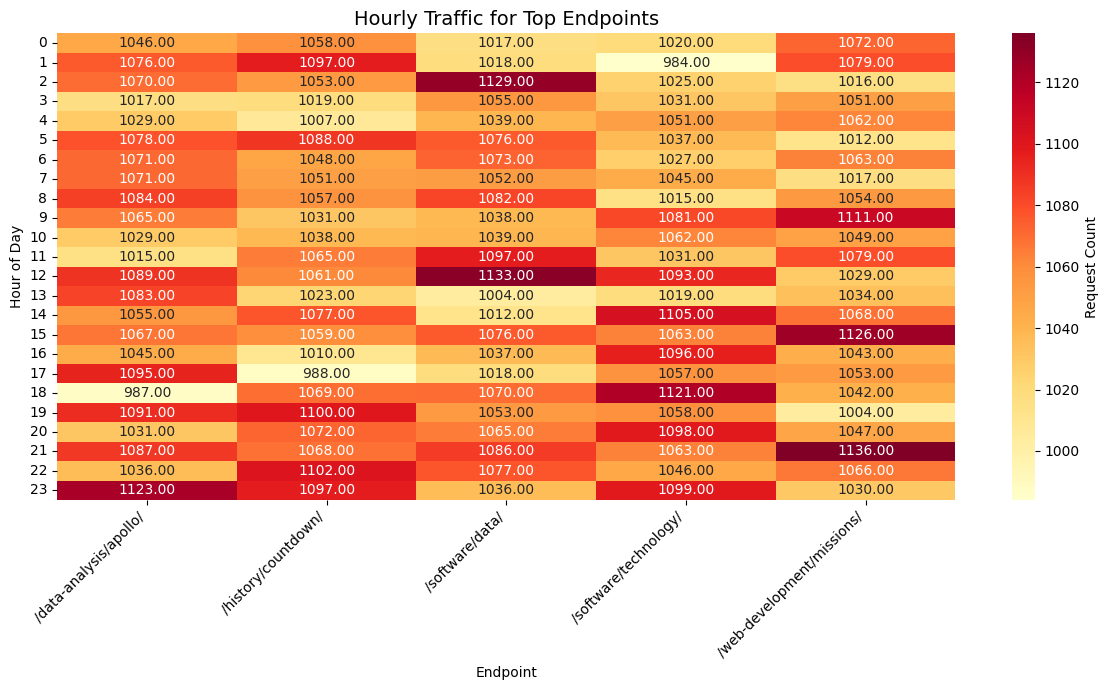

In [ ]:
# query 2 graph
import matplotlib.pyplot as plot
import seaborn as sns
import pandas as pd


final_result_pd = final_result_df.select(
    "visit_date", "hour_of_day", "Endpoint", "request_count"
).toPandas()

# Step 2: Filter for top N endpoints
top_endpoints = (
    final_result_pd.groupby("Endpoint")["request_count"]
    .sum()
    .sort_values(ascending=False)
    .head(5)  # Top 5 endpoints
    .index
)

filtered_data = final_result_pd[final_result_pd["Endpoint"].isin(top_endpoints)]

# Step 3: Aggregate the data to create a summary for visualization
summary_data = filtered_data.groupby(["hour_of_day", "Endpoint"])["request_count"].sum().reset_index()


heat_map_data = summary_data.pivot_table(
    index="hour_of_day",
    columns="Endpoint",
    values="request_count",
    fill_value=0
)


plot.figure(figsize=(12, 7))
sns.heatmap(
    heat_map_data,
    cmap="YlOrRd",
    annot=True,
    fmt=".2f",  # Format the numbers to 2 decimal places
    cbar_kws={'label': 'Request Count'}
)


plot.title("Hourly Traffic for Top Endpoints", fontsize=14)
plot.xlabel("Endpoint", fontsize=10)
plot.ylabel("Hour of Day", fontsize=10)
plot.xticks(rotation=45, ha="right")
plot.yticks(rotation=0)
plot.tight_layout()

# Show the plot
plot.show()



In [ ]:
# Task1  query1

from pyspark.sql.functions import regexp_extract
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# - DF Creation with REGEX
file_path ="/content/web.log"
df = spark.read.text(file_path)
level2_log_pattern = r'(\S+) - - \[([^\]]+)] "(.*?) (.*?) (.*?)" (\d+) (\d+) (.+)'

level1_parsed_df = df \
    .withColumn("IP", regexp_extract("value", level2_log_pattern, 1)) \
    .withColumn("Timestamp", F.to_timestamp(F.regexp_extract("value", level2_log_pattern, 2), "dd/MMM/yyyy:HH:mm:ss")) \
    .withColumn("Endpoint", regexp_extract("value", level2_log_pattern, 4)) \
    .withColumn("Status", regexp_extract("value", level2_log_pattern, 6).cast("int")) \
    .withColumn("Bytes", F.regexp_extract("value", level2_log_pattern, 7).cast("int"))

# query 1
traffic_df = level1_parsed_df \
    .withColumn("visit_date", F.to_date("Timestamp")) \
    .withColumn("hour_of_day", F.hour("Timestamp"))

# Calculate traffic per hour
traffic_hourly = traffic_df \
    .groupBy("IP", "visit_date", "hour_of_day") \
    .agg(F.count("*").alias("request_count"))

# Define a window to rank hours by request count for each IP
window_spec = Window.partitionBy("IP").orderBy(F.col("request_count").desc())

# Use window function to rank hours and filter the peak hour
peak_hours_df = traffic_hourly \
    .withColumn("rank", F.row_number().over(window_spec)) \
    .filter(F.col("rank") == 1)  # Keep only the top-ranking hour

# Show the result
peak_hours_df.show(truncate=False)


+-----------+----------+-----------+-------------+----+
|IP         |visit_date|hour_of_day|request_count|rank|
+-----------+----------+-----------+-------------+----+
|1.1.104.46 |2023-01-28|14         |1            |1   |
|1.1.119.183|2023-07-02|20         |1            |1   |
|1.1.120.92 |2023-04-18|12         |1            |1   |
|1.1.134.30 |2022-12-08|6          |1            |1   |
|1.1.134.82 |2023-08-16|6          |1            |1   |
|1.1.153.25 |2023-06-14|14         |1            |1   |
|1.1.162.204|2022-04-23|18         |1            |1   |
|1.1.163.231|2022-11-16|11         |1            |1   |
|1.1.177.217|2023-06-21|18         |1            |1   |
|1.1.186.69 |2022-04-04|11         |1            |1   |
|1.1.189.124|2022-05-14|3          |1            |1   |
|1.1.197.41 |2022-09-19|14         |1            |1   |
|1.1.198.6  |2023-05-19|14         |1            |1   |
|1.1.199.213|2022-01-02|19         |1            |1   |
|1.1.20.113 |2022-01-06|22         |1           

<ipython-input-14-b280406ef1e1>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=peak_hours_top, x="IP", y="request_count", palette="viridis")


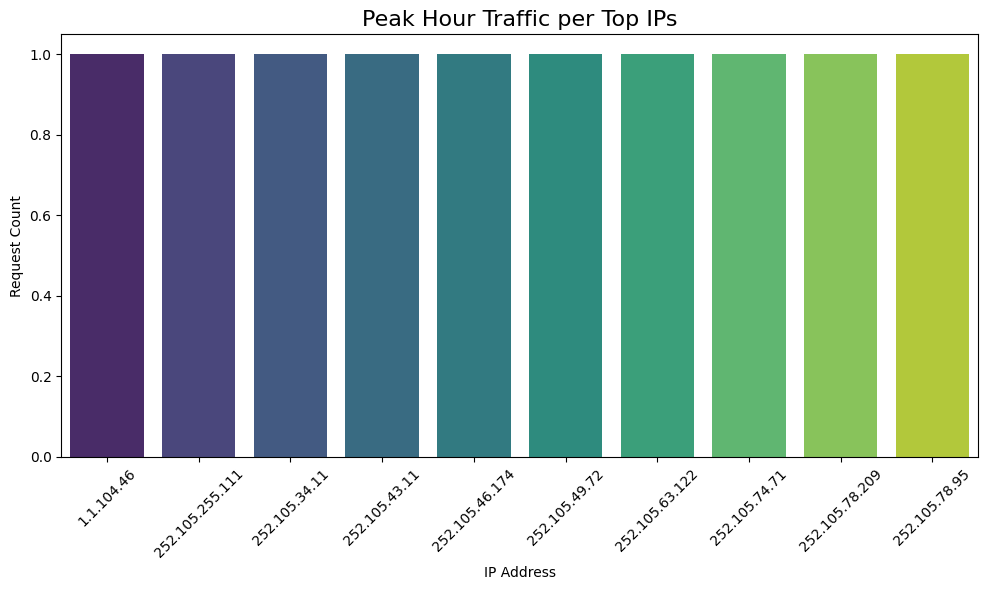

In [ ]:
# query1-graph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plot



peak_hours_pd = peak_hours_df.select("IP", "hour_of_day", "request_count").toPandas()


peak_hours_pd.sort_values(by="request_count", ascending=False, inplace=True)

# Limit to the top N IPs (e.g., top 10 IPs with the highest request count)
top_n_ips = 10
peak_hours_top = peak_hours_pd.groupby("IP").agg({
    "request_count": "sum",  # Sum request_count for each IP
}).reset_index()

# Sort and select the top N IPs
peak_hours_top = peak_hours_top.sort_values(by="request_count", ascending=False).head(top_n_ips)

# Reduce the figure size to avoid excessive image size
plot.figure(figsize=(10, 6))

# Plot using Seaborn for better aesthetics
sns.barplot(data=peak_hours_top, x="IP", y="request_count", palette="viridis")


plot.xlabel('IP Address', fontsize=10)
plot.ylabel('Request Count', fontsize=10)
plot.title('Peak Hour Traffic per Top IPs', fontsize=16)
plot.xticks(rotation=45, fontsize=10)


plot.tight_layout()


plot.show()



In [ ]:
#  query 2
hourly_traffic_df = level1_parsed_df \
    .withColumn("visit_date", F.to_date("Timestamp")) \
    .withColumn("hour_of_day", F.hour("Timestamp")) \
    .groupBy("visit_date", "hour_of_day") \
    .agg(
        F.expr("COUNT(1)").alias("request_count"),
        F.expr("SUM(Bytes)").alias("total_data_transferred")
    ) \
    .orderBy(F.desc("visit_date"), "hour_of_day")

hourly_traffic_df.show(truncate=False)


+----------+-----------+-------------+----------------------+
|visit_date|hour_of_day|request_count|total_data_transferred|
+----------+-----------+-------------+----------------------+
|2023-11-13|0          |201          |10139088              |
|2023-11-13|1          |197          |10462190              |
|2023-11-13|2          |193          |9938587               |
|2023-11-13|3          |172          |9230149               |
|2023-11-13|4          |168          |8023130               |
|2023-11-13|5          |196          |10172668              |
|2023-11-13|6          |193          |9633912               |
|2023-11-13|7          |169          |8535512               |
|2023-11-13|8          |166          |7932244               |
|2023-11-13|9          |194          |10065286              |
|2023-11-13|10         |173          |9035432               |
|2023-11-13|11         |183          |9160138               |
|2023-11-13|12         |197          |10609773              |
|2023-11

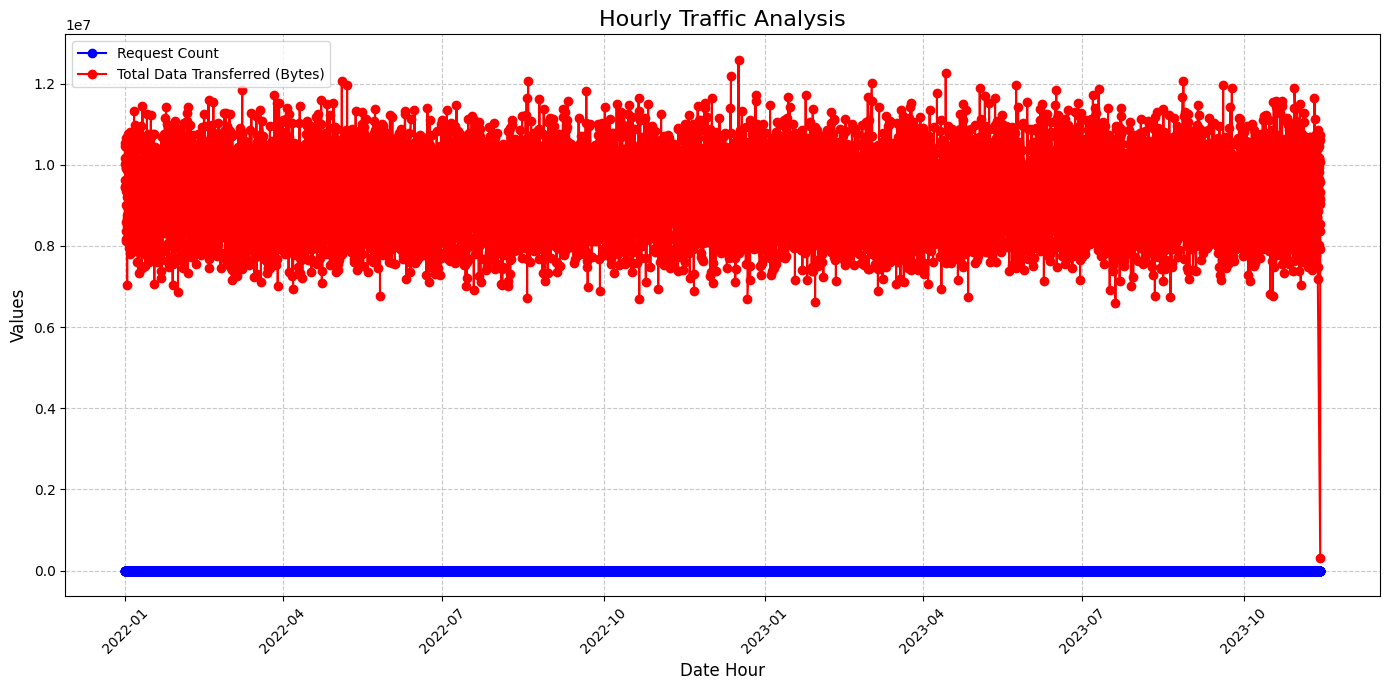

In [ ]:
#query2 graph
import matplotlib.pyplot as plot
import pandas as pd


hourly_traffic_pd = hourly_traffic_df.toPandas()

# Create a combined 'Date Hour' column for easier plotting
hourly_traffic_pd['Date Hour'] = pd.to_datetime(
    hourly_traffic_pd['visit_date'].astype(str) + ' ' + hourly_traffic_pd['hour_of_day'].astype(str) + ':00:00'
)

# Plot request count as a line chart
plot.figure(figsize=(14, 7))
plot.plot(hourly_traffic_pd['Date Hour'], hourly_traffic_pd['request_count'], label="Request Count", marker='o', color='b')

# Plot total data transferred as a secondary line chart
plot.plot(hourly_traffic_pd['Date Hour'], hourly_traffic_pd['total_data_transferred'], label="Total Data Transferred (Bytes)", marker='o', color='r')


plot.xlabel('Date Hour', fontsize=12)
plot.ylabel('Values', fontsize=12)
plot.title('Hourly Traffic Analysis', fontsize=16)
plot.legend()

plot.grid(True, linestyle='--', alpha=0.7)


plot.xticks(rotation=45, fontsize=10)


plot.tight_layout()

plot.show()


In [ ]:
# Task 1
from pyspark.sql.window import Window

from pyspark.sql import functions as F

# - DF Creation with REGEX
file_path ="/content/web.log"
df = spark.read.text(file_path)
Priyanka_log_pattern = r'(\S+) - - \[([^\]]+)] "(.*?) (.*?) (.*?)" (\d+) (\d+) (.+)'

level3_parsed_df = df \
    .withColumn("IP", F.regexp_extract("value", Priyanka_log_pattern, 1)) \
    .withColumn("Timestamp", F.regexp_extract("value", Priyanka_log_pattern, 2)) \
    .withColumn("Endpoint", F.regexp_extract("value", Priyanka_log_pattern, 4)) \
    .withColumn("Bytes", F.regexp_extract("value", Priyanka_log_pattern, 7).cast("int")) \
    .withColumn("Timestamp", F.to_timestamp(F.col("Timestamp"), "dd/MMM/yyyy:HH:mm:ss"))  # Convert to timestamp


# Query 1
# Calculate rolling traffic
rolling_traffic_df = level3_parsed_df \
    .withColumn("epoch_seconds", F.unix_timestamp("Timestamp")) \
    .withColumn(
        "rolling_traffic",
        F.count("*").over(
            Window.partitionBy("IP")
            .orderBy("epoch_seconds")
            .rangeBetween(-3600, 0)  # 1-hour range in seconds
        )
    ) \
    .drop("epoch_seconds")
result_df = rolling_traffic_df.select("IP", "Timestamp", "rolling_traffic")

# Show the results

result_df.orderBy(F.col("rolling_traffic").desc(), "IP", "epoch_seconds").show(truncate=False)




# Query 2
# Specify the target endpoint (e.g., "/api/v1/resource")
target_endpoint = "/security/firewall/"

# Filter DataFrame for the specific endpoint
filtered_df = level3_parsed_df.filter(F.col("Endpoint") == target_endpoint)

# Count the requests per IP for the target endpoint
user_requests_df = filtered_df \
    .groupBy("IP") \
    .agg(F.count("*").alias("request_count"))

# Define a window to rank IPs globally by request count
window_spec = Window.orderBy(F.col("request_count").desc())

# Rank IPs and filter the top 5 users
top_users_df = user_requests_df \
    .withColumn("rank", F.row_number().over(window_spec)) \
    .filter(F.col("rank") <= 5)  # Top 5 users

# Show the result
top_users_df.show(truncate=False)

+-----------+-------------------+---------------+
|IP         |Timestamp          |rolling_traffic|
+-----------+-------------------+---------------+
|1.1.104.46 |2023-01-28 14:37:27|1              |
|1.1.108.121|2022-09-17 07:15:06|1              |
|1.1.118.39 |2023-01-15 16:13:25|1              |
|1.1.119.183|2023-07-02 20:05:44|1              |
|1.1.120.92 |2023-04-18 12:19:24|1              |
|1.1.126.167|2022-10-23 07:53:08|1              |
|1.1.134.30 |2022-12-08 06:46:51|1              |
|1.1.134.82 |2023-08-16 06:10:41|1              |
|1.1.138.78 |2022-09-07 14:12:40|1              |
|1.1.153.25 |2023-06-14 14:02:42|1              |
|1.1.162.204|2022-04-23 18:23:24|1              |
|1.1.163.231|2022-11-16 11:52:50|1              |
|1.1.168.134|2022-12-18 22:46:50|1              |
|1.1.169.178|2022-07-06 10:46:26|1              |
|1.1.17.167 |2023-05-31 09:08:16|1              |
|1.1.177.217|2023-06-21 18:40:05|1              |
|1.1.186.69 |2022-04-04 11:23:34|1              |


<ipython-input-21-04f7909caee5>:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolling_traffic_pd['hourly_timestamp'] = rolling_traffic_pd['Timestamp'].dt.floor('H')


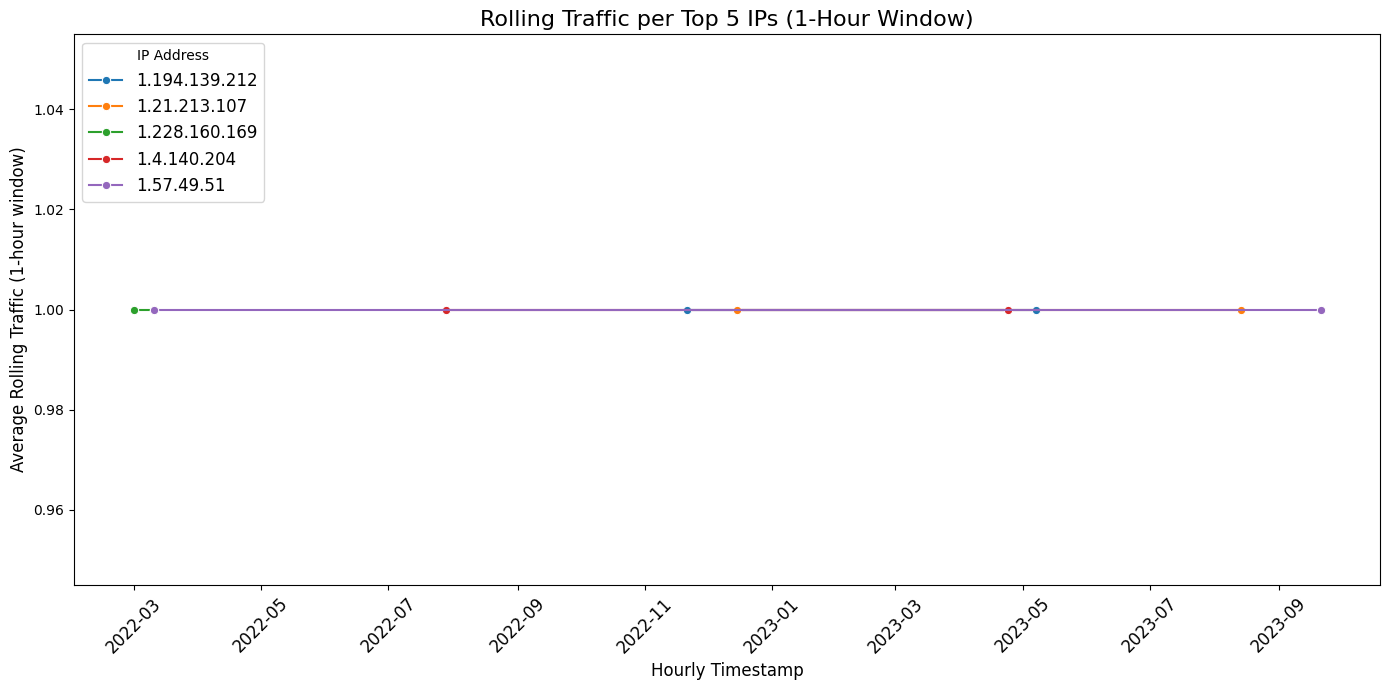

In [ ]:
# query 1 graph
import matplotlib.pyplot as plot
import pandas as pd
import seaborn as sns

# Step 1: Aggregate data to reduce granularity
rolling_traffic_pd = result_df.select("IP", "Timestamp", "rolling_traffic").toPandas()

# Convert 'Timestamp' to Pandas datetime format
rolling_traffic_pd['Timestamp'] = pd.to_datetime(rolling_traffic_pd['Timestamp'])

# Sort values for proper grouping
rolling_traffic_pd.sort_values(by=["IP", "Timestamp"], inplace=True)

# Aggregate data by IP and hourly intervals
rolling_traffic_pd['hourly_timestamp'] = rolling_traffic_pd['Timestamp'].dt.floor('H')
aggregated_df = rolling_traffic_pd.groupby(["IP", "hourly_timestamp"]) \
    .agg({"rolling_traffic": "mean"}) \
    .reset_index()

# Step 2: Focus on top 5 IPs with the highest traffic
top_ips = (
    rolling_traffic_pd.groupby("IP")["rolling_traffic"]
    .sum()
    .nlargest(5)
    .index
)

filtered_df = aggregated_df[aggregated_df['IP'].isin(top_ips)]

# Step 3: Plot the data
plot.figure(figsize=(14, 7))
sns.lineplot(
    data=filtered_df,
    x="hourly_timestamp",
    y="rolling_traffic",
    hue="IP",
    marker="o",
    palette="tab10"
)

# Add labels and title
plot.xlabel('Hourly Timestamp', fontsize=12)
plot.ylabel('Average Rolling Traffic (1-hour window)', fontsize=12)
plot.title('Rolling Traffic per Top 5 IPs (1-Hour Window)', fontsize=16)
plot.xticks(rotation=45, fontsize=12)
plot.legend(title="IP Address", fontsize=12, loc='upper left')


plot.tight_layout()

plot.show()


<ipython-input-23-b116dc4e9663>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_users_pd, x="IP", y="request_count", palette="coolwarm")


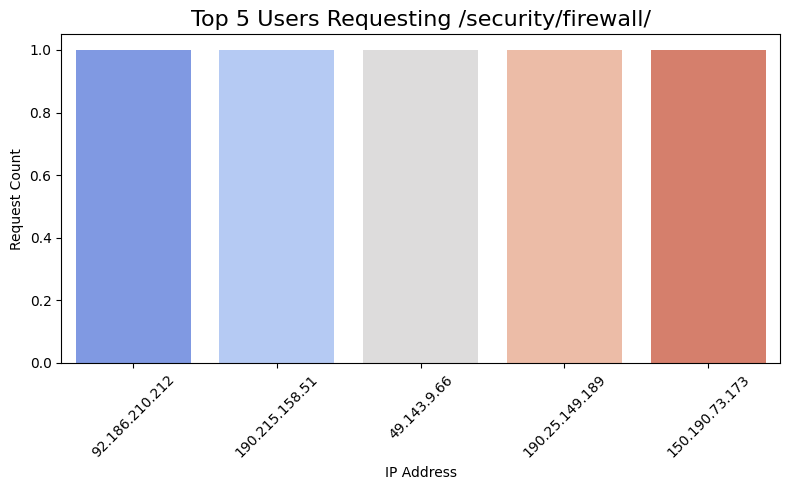

In [ ]:
# query2 graph
import matplotlib.pyplot as plot
import pandas as pd
import seaborn as sns


top_users_pd = top_users_df.select("IP", "request_count").toPandas()

# Sort by request_count for cleaner plotting
top_users_pd.sort_values(by="request_count", ascending=False, inplace=True)


plot.figure(figsize=(8, 5))
sns.barplot(data=top_users_pd, x="IP", y="request_count", palette="coolwarm")


plot.xlabel('IP Address', fontsize=10)
plot.ylabel('Request Count', fontsize=10)
plot.title('Top 5 Users Requesting /security/firewall/', fontsize=16)
plot.xticks(rotation=45, fontsize=10)


plot.tight_layout()
plot.show()


In [ ]:
# Task 1
# DF Creation with REGEX

from pyspark.sql.functions import regexp_extract

from pyspark.sql.window import Window

from pyspark.sql import functions as F


file_path ="/content/web.log"
level3_df = spark.read.text(file_path)
level3_log_pattern = r'(\S+) - - \[([^\]]+)] "(.*?) (.*?) (.*?)" (\d+) (\d+) (.+)'

level4_parsed_df = df \
    .withColumn("IP", regexp_extract("value", level3_log_pattern, 1)) \
    .withColumn("Timestamp", F.regexp_extract("value", level3_log_pattern, 2)) \
    .withColumn("Method", regexp_extract("value", level3_log_pattern, 3)) \
    .withColumn("Endpoint", regexp_extract("value", level3_log_pattern, 4)) \
    .withColumn("Protocol", regexp_extract("value", level3_log_pattern, 5)) \
    .withColumn("Status", regexp_extract("value", level3_log_pattern, 6).cast("int")) \
    .withColumn("Bytes", regexp_extract("value", level3_log_pattern, 7).cast("int")) \
    .withColumn("Message", regexp_extract("value", level3_log_pattern, 8)) \
    .withColumn("Timestamp",F.to_timestamp(F.col("Timestamp"), "dd/MMM/yyyy:HH:mm:ss")  # Convert string to timestamp
    )


# Query 1:
session_timeout = 7200  # Session timeout in seconds
window_spec_ip = Window.partitionBy("IP").orderBy("Timestamp")

level4_parsed_df = level4_parsed_df \
    .withColumn("previous_timestamp", F.lag("Timestamp").over(window_spec_ip)) \
    .withColumn("time_diff", F.unix_timestamp("Timestamp") - F.unix_timestamp("previous_timestamp")) \
    .withColumn("session_start", F.when(F.col("time_diff") > session_timeout, 1).otherwise(0))

# Assigning session IDs based on session start logic
level4_parsed_df = level4_parsed_df \
    .withColumn("session_id", F.sum("session_start").over(window_spec_ip.rowsBetween(Window.unboundedPreceding, 0)))

# Group by session_id and get session stats (request_count, total_bytes_transferred, etc.)
session_analysis_df = level4_parsed_df \
    .groupBy("session_id") \
    .agg(
        F.count("*").alias("request_count"),
        F.expr("sum(Bytes)").alias("total_bytes_transferred"),
        F.expr("min(Timestamp)").alias("session_start_time"),
        F.expr("max(Timestamp)").alias("session_end_time"),
        F.collect_list("Endpoint").alias("endpoints")
    )

# Step 4: Group by session ID and Endpoint to count occurrences
endpoint_counts_df = level4_parsed_df.groupBy("session_id", "Endpoint") \
    .agg(F.count("Endpoint").alias("endpoint_count"))

# Step 5: Use window function to rank endpoints within each session
window_spec_session = Window.partitionBy("session_id").orderBy(F.col("endpoint_count").desc())
ranked_endpoints_df = endpoint_counts_df.withColumn("rank", F.rank().over(window_spec_session))

# Step 6: Filter the most frequent endpoint for each session
most_frequent_endpoint_df = ranked_endpoints_df.filter(F.col("rank") == 1) \
    .select("session_id", "Endpoint")

# Step 7: Join most frequent endpoint back to session analysis DataFrame
session_analysis_df = session_analysis_df.join(
    most_frequent_endpoint_df.withColumnRenamed("Endpoint", "most_frequent_endpoint"),
    on="session_id",
    how="left"
)

# Step 8: Final Output (No limit)
session_analysis_df = session_analysis_df.select(
    "session_id",
    "request_count",
    "total_bytes_transferred",
    "session_start_time",
    "session_end_time",
    "most_frequent_endpoint"
)

# Display the final result without limit to get all sessions
session_analysis_df.show(truncate=False)



+----------+-------------+-----------------------+-------------------+-------------------+-----------------------------------------+
|session_id|request_count|total_bytes_transferred|session_start_time |session_end_time   |most_frequent_endpoint                   |
+----------+-------------+-----------------------+-------------------+-------------------+-----------------------------------------+
|0         |2998935      |151443952332           |2022-01-01 00:01:34|2023-11-13 17:00:58|/data-analysis/apollo/                   |
|1         |1065         |53499836               |2022-01-10 18:36:30|2023-11-13 13:46:39|/software/frontend-frameworks-comparison/|
+----------+-------------+-----------------------+-------------------+-------------------+-----------------------------------------+



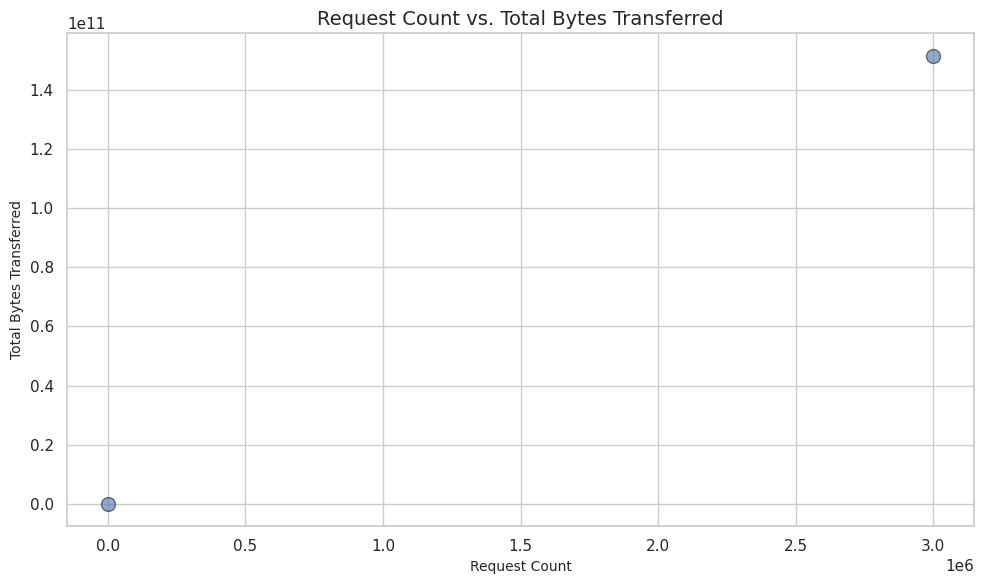

<ipython-input-52-8ad361af3a60>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_endpoints.index, y=top_endpoints['total_requests'], palette='Blues_d')


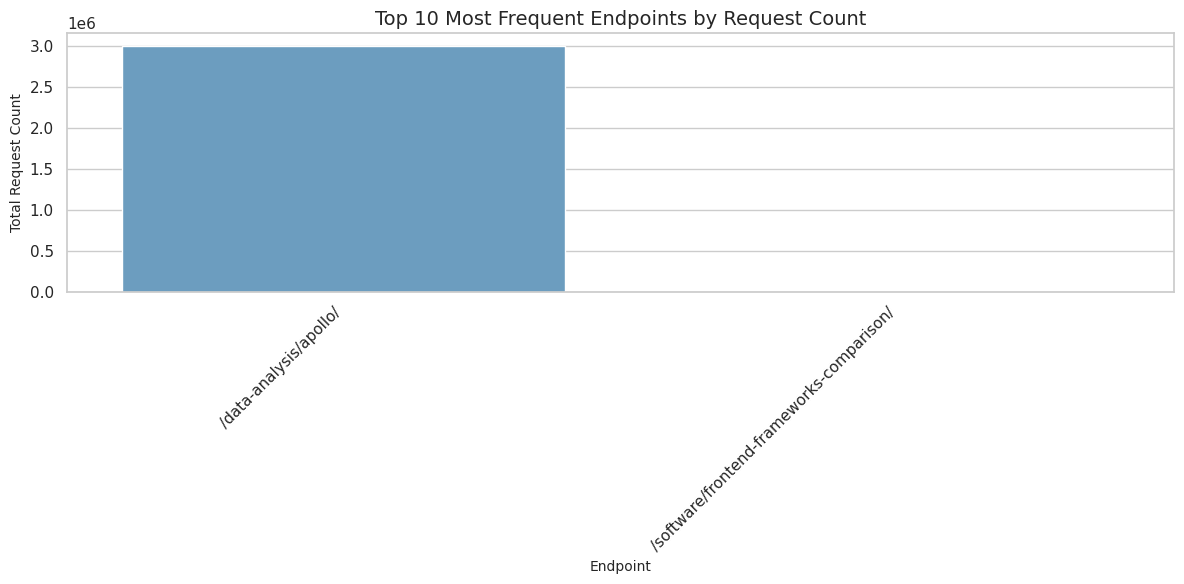

<ipython-input-52-8ad361af3a60>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=session_analysis_pd_df['session_id'], y=session_analysis_pd_df['request_count'], palette='coolwarm')


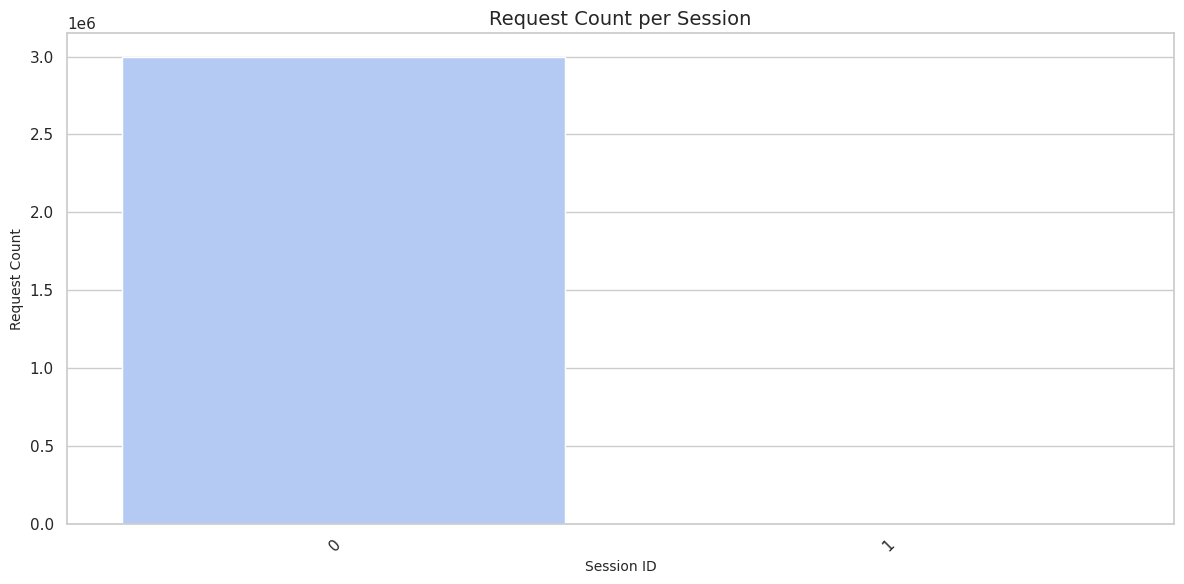

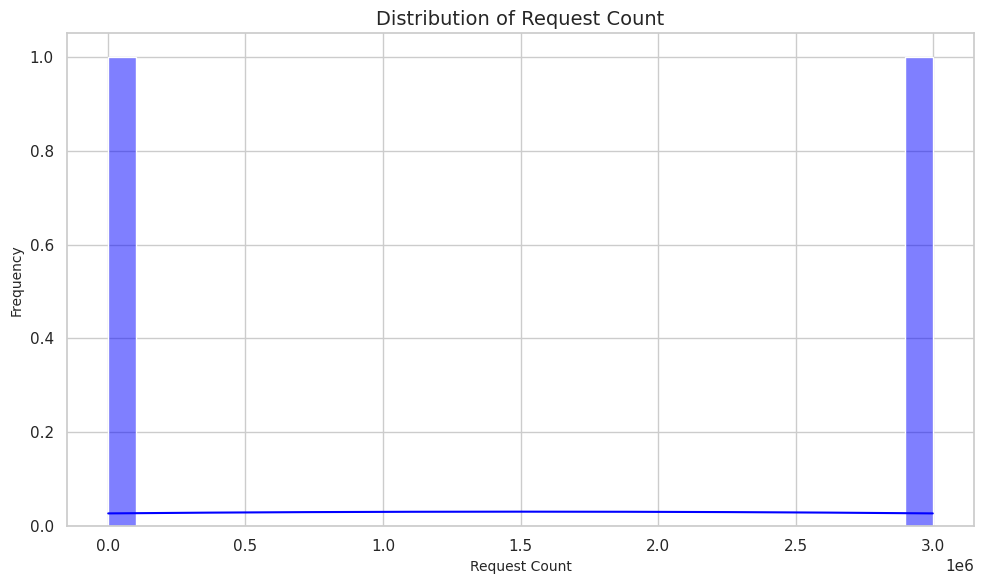

In [ ]:
#  query1 graph
import matplotlib.pyplot as plot
import seaborn as sns
import pandas as pd

# DF --> Pandas
session_analysis_pd_df = session_analysis_df.toPandas()

# Set Seaborn style for cleaner visuals
sns.set(style="whitegrid")

# 1. Scatter Plot: Request Count vs. Total Bytes Transferred
plot.figure(figsize=(10, 6))
plot.scatter(
    session_analysis_pd_df['request_count'],
    session_analysis_pd_df['total_bytes_transferred'],
    alpha=0.6, c='b', edgecolors='k', s=100
)
plot.title("Request Count vs. Total Bytes Transferred", fontsize=14)
plot.xlabel("Request Count", fontsize=10)
plot.ylabel("Total Bytes Transferred", fontsize=10)
plot.tight_layout()
plot.show()

# 2. Bar Plot: Request Count per Endpoint (Top 10)
top_endpoints = session_analysis_pd_df.groupby('most_frequent_endpoint').agg(
    total_requests=pd.NamedAgg(column='request_count', aggfunc='sum')
).sort_values('total_requests', ascending=False).head(10)

plot.figure(figsize=(12, 6))
sns.barplot(x=top_endpoints.index, y=top_endpoints['total_requests'], palette='Blues_d')
plot.title("Top 10 Most Frequent Endpoints by Request Count", fontsize=14)
plot.xlabel("Endpoint", fontsize=10)
plot.ylabel("Total Request Count", fontsize=10)
plot.xticks(rotation=45, ha='right')

plot.tight_layout()

plot.show()

# 3. Bar Plot: Request Count per Session
plot.figure(figsize=(12, 6))
sns.barplot(x=session_analysis_pd_df['session_id'], y=session_analysis_pd_df['request_count'], palette='coolwarm')
plot.title("Request Count per Session", fontsize=14)
plot.xlabel("Session ID", fontsize=10)
plot.ylabel("Request Count", fontsize=10)
plot.xticks(rotation=45, ha='right')
plot.tight_layout()
plot.show()

# 4. Histogram: Distribution of Request Count
plot.figure(figsize=(10, 6))
sns.histplot(session_analysis_pd_df['request_count'], kde=True, color='blue', bins=30)
plot.title("Distribution of Request Count", fontsize=14)
plot.xlabel("Request Count", fontsize=10)
plot.ylabel("Frequency", fontsize=10)
plot.tight_layout()
plot.show()


In [ ]:
# Task 1
# - Query 2

from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Step 1: messages
message_analysis_df = level4_parsed_df.withColumn(
    "message_category",
    F.when(F.col("Message").like("%error%"), "Error")
    .when(F.col("Message").like("%not found%"), "404 Not Found")
    .when(F.col("Message").like("%timeout%"), "Timeout")
    .when(F.col("Message").like("%success%"), "Success")
    .when(F.col("Message").like("%Caution%"), "Caution")
    .when(F.col("Message").like("%Informational%"), "Informational")
    .when(F.col("Message").like("%Debug%"), "Debug")
    .when(F.col("Message").like("%FYI%"), "FYI")
    .when(F.col("Message").like("%Update%"), "Update")
    .otherwise("Other")
)

# Step 2: Extracting additional time-related information
message_analysis_df = message_analysis_df.withColumn(
    "visit_date", F.to_date(F.col("Timestamp"))
).withColumn(
    "hour_of_day", F.hour(F.col("Timestamp"))
)

# Step 3: Aggregating message counts and unique IPs per message category per day and hour
message_traffic_analysis_df = message_analysis_df.groupBy("visit_date", "hour_of_day", "message_category") \
    .agg(
        F.count("*").alias("message_count"),
        F.countDistinct("IP").alias("unique_ips")
    )

# Step 4: Aggregating total response size per message category per day and hour
# Alias the `parsed_df` and `message_analysis_df` to avoid ambiguity in the `Bytes` column
parsed_df_alias = level4_parsed_df.alias("p")
message_analysis_df_alias = message_analysis_df.alias("m")

response_size_analysis_df = parsed_df_alias.join(
    message_analysis_df_alias,
    on=["IP", "Timestamp"],
    how="inner"
).groupBy("m.visit_date", "m.hour_of_day", "m.message_category") \
    .agg(
        F.sum("p.Bytes").alias("total_response_size")  # Explicitly refer to `Bytes` from `parsed_df` alias
    )

# Step 5: Joining the traffic analysis and response size analysis
final_df = message_traffic_analysis_df.join(
    response_size_analysis_df,
    on=["visit_date", "hour_of_day", "message_category"],
    how="inner"
)

# Step 6: Sorting the result
final_result_df = final_df.orderBy(
    F.col("visit_date").desc(),
    F.col("hour_of_day").desc(),
    F.col("message_category")
)

# Show the result
print("Result Using PySpark's DataFrame API")
final_result_df.show(truncate=False)


# Register the DataFrame as a temporary view
level4_parsed_df.createOrReplaceTempView("parsed_logs")

# SQL query for message categorization and aggregation
query = """
SELECT
    to_date(Timestamp) AS visit_date,
    hour(Timestamp) AS hour_of_day,
    CASE
        WHEN Message LIKE '%error%' THEN 'Error'
        WHEN Message LIKE '%not found%' THEN '404 Not Found'
        WHEN Message LIKE '%timeout%' THEN 'Timeout'
        WHEN Message LIKE '%success%' THEN 'Success'
        WHEN Message LIKE '%Caution%' THEN 'Caution'
        WHEN Message LIKE '%Informational%' THEN 'Informational'
        WHEN Message LIKE '%Debug%' THEN 'Debug'
        WHEN Message LIKE '%FYI%' THEN 'FYI'
        WHEN Message LIKE '%Update%' THEN 'Update'
        ELSE 'Other'
    END AS message_category,
    COUNT(*) AS message_count,
    COUNT(DISTINCT IP) AS unique_ips,
    SUM(Bytes) AS total_response_size
FROM
    parsed_logs
GROUP BY
    visit_date, hour_of_day, message_category
ORDER BY
    visit_date DESC, hour_of_day DESC, message_category
"""

# Execute the SQL query
final_result_df = spark.sql(query)

# Show the result
print("Result Using SQL query")
final_result_df.show(truncate=False)


Result Using PySpark's DataFrame API
+----------+-----------+----------------+-------------+----------+-------------------+
|visit_date|hour_of_day|message_category|message_count|unique_ips|total_response_size|
+----------+-----------+----------------+-------------+----------+-------------------+
|2023-11-13|17         |Debug           |2            |2         |175130             |
|2023-11-13|17         |Other           |2            |2         |139993             |
|2023-11-13|16         |Caution         |26           |26        |1155394            |
|2023-11-13|16         |Debug           |77           |77        |3686838            |
|2023-11-13|16         |FYI             |19           |19        |1082359            |
|2023-11-13|16         |Informational   |21           |21        |999472             |
|2023-11-13|16         |Other           |43           |43        |2390774            |
|2023-11-13|16         |Update          |28           |28        |1414392            |
|2023-

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


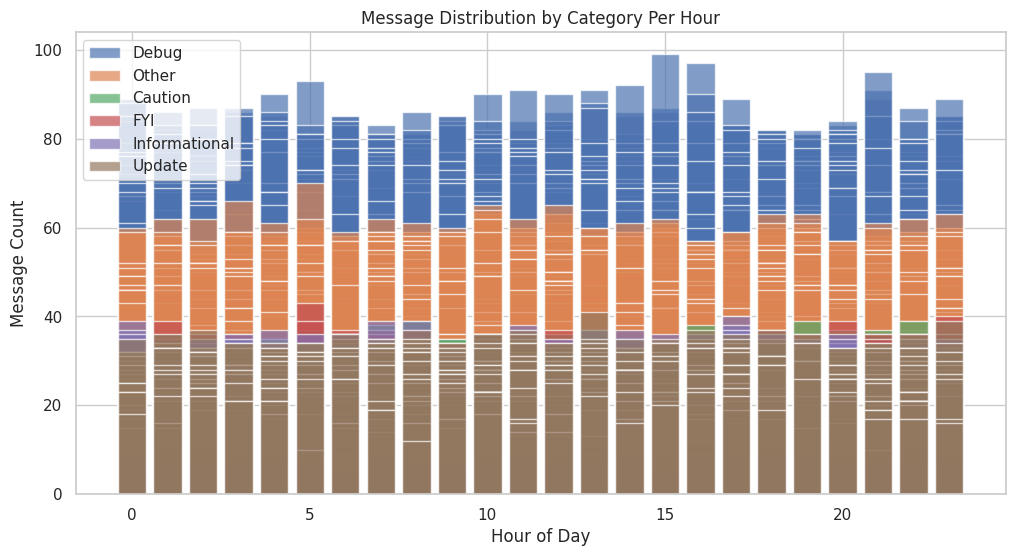

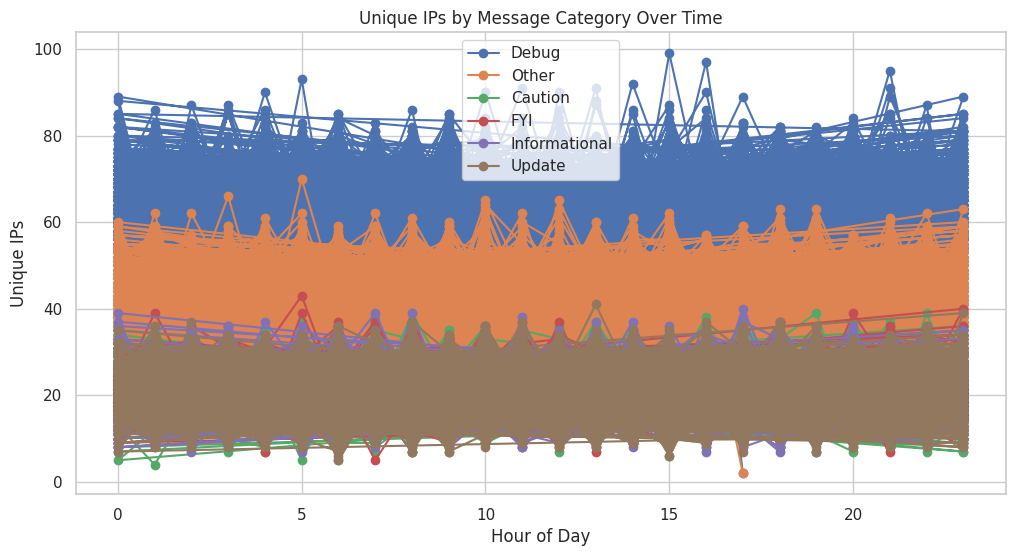

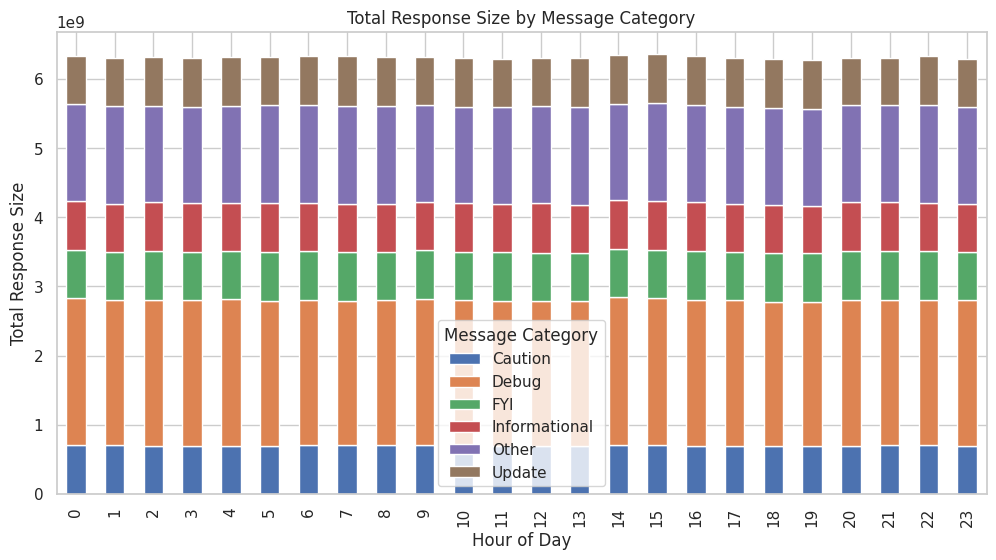

In [ ]:
# Task 1 query 2 graph

import matplotlib.pyplot as plot
import pandas as pd

# DF -> Pandas
final_pandas_df = final_result_df.toPandas()

# Plot 1: Bar Graph - Message Category Distribution Per Hour
plot.figure(figsize=(12, 6))
for category in final_pandas_df['message_category'].unique():
    subset = final_pandas_df[final_pandas_df['message_category'] == category]
    plot.bar(subset['hour_of_day'], subset['message_count'], label=category, alpha=0.7)
plot.xlabel('Hour of Day')
plot.ylabel('Message Count')
plot.title('Message Distribution by Category Per Hour')
plot.legend()
plot.show()

# Plot 2: Line Graph - Unique IP Counts Over Time
plot.figure(figsize=(12, 6))
for category in final_pandas_df['message_category'].unique():
    subset = final_pandas_df[final_pandas_df['message_category'] == category]
    plot.plot(subset['hour_of_day'], subset['unique_ips'], label=category, marker='o')
plot.xlabel('Hour of Day')
plot.ylabel('Unique IPs')
plot.title('Unique IPs by Message Category Over Time')
plot.legend()
plot.show()

# Plot 3: Stacked Bar Chart - Total Response Size by Category
response_data = final_pandas_df.pivot_table(
    index='hour_of_day', columns='message_category', values='total_response_size', aggfunc='sum', fill_value=0
)
response_data.plot(kind='bar', stacked=True, figsize=(12, 6))
plot.xlabel('Hour of Day')
plot.ylabel('Total Response Size')
plot.title('Total Response Size by Message Category')
plot.legend(title='Message Category')
plot.show()




# **Task 2 - Data Processing using PySpark RDD [40 marks]**

---


In [ ]:
# Task 2
# Basic query

import re
from pyspark.sql import Row
from datetime import datetime
# from pyspark.sql.functions import col
# from pyspark.sql import SparkSession
#

level1_log_pattern = r'(\S+) - - \[([^\]]+)] "(.*?) (.*?) (.*?)" (\d+) (\d+)'

# Step 1: Read the log file as an RDD
log_rdd = spark.sparkContext.textFile(file_path)

# Step 2: Parse the log lines using the regular expression pattern
level1_log_rdd = log_rdd.map(lambda line: re.match(level1_log_pattern, line)) \
                    .filter(lambda x: x is not None) \
                    .map(lambda x: Row(
                        IP=x.group(1),
                        Timestamp=datetime.strptime(x.group(2), "%d/%b/%Y:%H:%M:%S"),  # Convert to datetime
                        Endpoint=x.group(4),
                        Protocol=x.group(5),
                        Status=int(x.group(6)),
                        Bytes=int(x.group(7)),
                        visit_date=datetime.strptime(x.group(2), "%d/%b/%Y:%H:%M:%S").date()  # Extract date from Timestamp
                    ))


unique_visitors_rdd = level1_log_rdd.map(lambda row: (row["visit_date"], row["IP"])) \
                            .distinct()

# Reduce by visit_date to count the unique visitors
unique_visitors_per_day_rdd = unique_visitors_rdd.map(lambda x: (x[0], 1)) \
                                                .reduceByKey(lambda a, b: a + b)


unique_visitors_sorted = unique_visitors_per_day_rdd.sortByKey(ascending=False).collect()

# Print the results
print(f"{'Visit Date':<15} {'Unique Visitors':>15}")
print("-" * 35)
for date, count in unique_visitors_sorted:
    # Format the date before printing
    formatted_date = date.strftime('%Y-%m-%d')  # Change the format as needed
    print(f"{formatted_date:<15} {count:>15}")

Visit Date      Unique Visitors
-----------------------------------
2023-11-13                 3154
2023-11-12                 4323
2023-11-11                 4454
2023-11-10                 4489
2023-11-09                 4444
2023-11-08                 4401
2023-11-07                 4477
2023-11-06                 4395
2023-11-05                 4404
2023-11-04                 4526
2023-11-03                 4359
2023-11-02                 4389
2023-11-01                 4433
2023-10-31                 4395
2023-10-30                 4503
2023-10-29                 4319
2023-10-28                 4384
2023-10-27                 4279
2023-10-26                 4377
2023-10-25                 4325
2023-10-24                 4388
2023-10-23                 4382
2023-10-22                 4377
2023-10-21                 4381
2023-10-20                 4519
2023-10-19                 4533
2023-10-18                 4428
2023-10-17                 4337
2023-10-16                 4442
2023

In [ ]:

# Advanced query 1

result = (
    level1_log_rdd
    .filter(lambda row: 400 <= row["Status"] < 600)  # Filter for error statuses (4xx, 5xx)
    .map(lambda row: (row["Endpoint"], 1))  # Map to (IP, 1) for each error
    .reduceByKey(lambda x, y: x + y)  # Count errors for each IP
    .filter(lambda x: x[1] > 5)  # Filter Endpoints with more than 5 errors
    .sortBy(lambda x: x[1], ascending=False)
)

# Collect and display the results
print(f"{'Endpoint':<50} {'Error Count':>15}")
print("-" * 65)
for endpoint, count in result.collect():
    print(f"{endpoint:<50} {count:>15}")

Endpoint                                               Error Count
-----------------------------------------------------------------
/networking/deep-learning/                                    9197
/history/countdown/                                           9180
/data-analysis/countdown/                                     9170
/web-development/missions/                                    9130
/data-analysis/apollo/                                        9128
/history/apollo/                                              9115
/machine-learning/deep-learning/                              9111
/software/missions/                                           9109
/cloud-computing/aws-certification/                           9108
/security/aws-certification/                                  9099
/history/missions/                                            9097
/machine-learning/aws-certification/                          9089
/software/technology/                                         9

In [ ]:
# Advanced query 2
result = (
    level1_log_rdd
    .filter(lambda row: row["Protocol"] is not None and 400 <= row["Status"] < 600)  # Filter for valid protocol and error status
    .map(lambda row: ((row["Protocol"], row["Status"]), 1))  # Map to ((Protocol, Status), 1)
    .reduceByKey(lambda x, y: x + y)  # Aggregate error counts for each (Protocol, Status)
    .map(lambda x: (x[0][0], (x[0][1], x[1])))  # Transform into (Protocol, (Status, Count))
    .groupByKey()  # Group by Protocol to aggregate statuses
    .mapValues(lambda statuses: sorted(list(statuses), key=lambda x: -x[1]))  # Sort statuses by their counts in descending order
    .sortBy(lambda x: sum(count for _, count in x[1]), ascending=False)  # Sort protocols by total error counts
)


print("Protocol Error Breakdown and Ranking:")
for protocol, details in result.collect():
    print(f"\nProtocol: {protocol}")
    for status, count in details:
        print(f"  Status: {status}, Count: {count}")

Protocol Error Breakdown and Ranking:

Protocol: HTTPS/1.0
  Status: 500, Count: 71940
  Status: 414, Count: 71733
  Status: 416, Count: 71463
  Status: 415, Count: 71274
  Status: 404, Count: 71240

Protocol: HTTP/2.0
  Status: 414, Count: 71832
  Status: 415, Count: 71577
  Status: 416, Count: 71470
  Status: 404, Count: 71396
  Status: 500, Count: 71330

Protocol: HTTP/1.0
  Status: 404, Count: 71948
  Status: 415, Count: 71284
  Status: 500, Count: 71257
  Status: 416, Count: 71241
  Status: 414, Count: 71140


In [ ]:
# Task 2
# Basic query

log_pattern = r'(\S+) - - \[([^\]]+)] "(.*?) (.*?) (.*?)" (\d+) (\d+) (.+)'

# Read the log file into an RDD
rdd = spark.sparkContext.textFile(file_path)

# Parse the RDD
level2_log_rdd = rdd.map(lambda line: re.match(log_pattern, line)) \
    .filter(lambda x: x is not None) \
    .map(lambda x: Row(
        IP=x.group(1),
        Timestamp=datetime.strptime(x.group(2), "%d/%b/%Y:%H:%M:%S"),
        Method=x.group(3),
        Endpoint=x.group(4),
        Protocol=x.group(5),
        Status=int(x.group(6)),
        Bytes=int(x.group(7)),
        Message=x.group(8)
    ))
# level2_log_rdd = level1_parsed_df.rdd
endpoint_request_rdd = level2_log_rdd.map(lambda row: (row["Endpoint"], row["Bytes"]))

# Use mapValues to get the maximum request size per endpoint
endpoint_max_request_size_rdd = endpoint_request_rdd.reduceByKey(lambda x, y: max(x, y))


sorted_max_request_size = endpoint_max_request_size_rdd.sortBy(lambda x: -x[1]).take(10)

# Print the results
print(f"{'Endpoint':<30} {'Max Request Size':>20}")
print("-" * 45)
for endpoint, max_size in sorted_max_request_size:
    print(f"{endpoint:<30} {max_size:>20}")

Endpoint                           Max Request Size
---------------------------------------------
/history/apollo-11/                          100000
/machine-learning/technology/                100000
/software/apollo-11/                         100000
/networking/apollo/                          100000
/images/missions/                            100000
/machine-learning/apollo/                    100000
/web-development/cybersecurity/               100000
/software/cybersecurity/                     100000
/security/apollo-11/                         100000
/software/aws-certification/                 100000


In [ ]:

# Advanced query 1
rdd = level2_log_rdd.map(lambda row: (row['Timestamp'].hour, (1, row['Bytes'])))

#Use aggregateByKey to calculate the visit count and total response size per hour
aggregated = rdd.aggregateByKey(
    (0, 0),  # Initial value: (count, total_response_size)
    lambda acc, value: (acc[0] + 1, acc[1] + value[1]),  # Combine function: count visits and sum response size
    lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1])  # Merge function: merge counts and response sizes
)


avg_response_size_by_hour = aggregated.mapValues(lambda x: x[1] / x[0] if x[0] != 0 else 0)


out = avg_response_size_by_hour.collect()
for hour, avg_size in out:
    print(f"Hour: {hour}, Average Response Size: {avg_size}")



Hour: 0, Average Response Size: 50497.15328659281
Hour: 13, Average Response Size: 50558.103551197906
Hour: 14, Average Response Size: 50569.05541961247
Hour: 1, Average Response Size: 50474.74197940192
Hour: 15, Average Response Size: 50563.94823228309
Hour: 2, Average Response Size: 50470.52735184252
Hour: 3, Average Response Size: 50474.9438882086
Hour: 16, Average Response Size: 50569.196268102336
Hour: 17, Average Response Size: 50519.9289977857
Hour: 4, Average Response Size: 50416.725716430185
Hour: 5, Average Response Size: 50534.55903685755
Hour: 18, Average Response Size: 50336.97008937152
Hour: 19, Average Response Size: 50347.81328649455
Hour: 6, Average Response Size: 50511.211837060706
Hour: 7, Average Response Size: 50620.967333706874
Hour: 20, Average Response Size: 50451.47435979462
Hour: 8, Average Response Size: 50504.42491358341
Hour: 21, Average Response Size: 50515.89310518853
Hour: 9, Average Response Size: 50551.527123848515
Hour: 22, Average Response Size: 5059

In [ ]:

# Advanced query 2
# def func(x):
#   return x+10
# print(func(5))
# lambda x: x+10

rdd_hourly_visits = level2_log_rdd.map(lambda row: (row['IP'], (row['Timestamp'].hour, 1)))

# Step 2: Use aggregateByKey to count visits per IP per hour
aggregated_visits = rdd_hourly_visits.aggregateByKey(
    {},  # Initialize as an empty dictionary to store visit counts per hour
    lambda acc, value: acc.update({value[0]: acc.get(value[0], 0) + value[1]}) or acc,  # Update visit count for each hour
    lambda acc1, acc2: {hour: acc1.get(hour, 0) + acc2.get(hour, 0) for hour in set(acc1) | set(acc2)}  # Merge visit counts from different partitions
)

# Step 3: Calculate total visits per IP and sort by visit count in descending order
total_visits_per_ip = aggregated_visits.mapValues(lambda x: sum(x.values()))  # Sum visit counts for each IP

top_10_ips = total_visits_per_ip.sortBy(lambda x: x[1], ascending=False).take(10)

for ip, visit_count in top_10_ips:
    print(f"IP: {ip}, Total Visits: {visit_count}")

IP: 61.203.220.155, Total Visits: 2
IP: 225.2.68.42, Total Visits: 2
IP: 189.15.120.110, Total Visits: 2
IP: 190.63.218.54, Total Visits: 2
IP: 18.133.225.189, Total Visits: 2
IP: 94.197.23.111, Total Visits: 2
IP: 221.28.12.178, Total Visits: 2
IP: 11.161.68.4, Total Visits: 2
IP: 146.73.243.9, Total Visits: 2
IP: 240.63.45.243, Total Visits: 2


In [ ]:
# Task 2
# basic query
log_pattern = r'(\S+) - - \[([^\]]+)] "(.*?) (.*?) (.*?)" (\d+) (\d+) (.+)'

# Read the log file into an RDD
rdd = spark.sparkContext.textFile(file_path)

# Parse the RDD
Priyanka_log_rdd = rdd.map(lambda line: re.match(log_pattern, line)) \
    .filter(lambda x: x is not None) \
    .map(lambda x: Row(
        IP=x.group(1),
        Timestamp=datetime.strptime(x.group(2), "%d/%b/%Y:%H:%M:%S"),
        Endpoint=x.group(4),
        Bytes=int(x.group(7))
    ))


ip_response_rdd = Priyanka_log_rdd.map(lambda row: (row["IP"], row["Bytes"]))


ip_total_response_rdd = ip_response_rdd.aggregateByKey(0,
                                                        lambda acc, value: acc + value,
                                                        lambda acc1, acc2: acc1 + acc2)

sorted_ip_response = ip_total_response_rdd.sortBy(lambda x: -x[1]).take(10)
# Display the result
print(f"{'IP Address':<20} {'Total Response Size':>20}")
print("-" * 45)
for ip, total_size in sorted_ip_response:
    print(f"{ip:<20} {total_size:>20}")


In [ ]:

# Advanced query 1
# Step 1: Map to (endpoint, bytes) tuples
rdd_endpoint_bytes = Priyanka_log_rdd.map(lambda row: (row['Endpoint'], row['Bytes']))

# Step 2: Use reduceByKey to sum bytes for each endpoint
total_bytes_per_endpoint = rdd_endpoint_bytes.reduceByKey(lambda a, b: a + b)


sorted_bytes = total_bytes_per_endpoint.sortBy(lambda x: x[1], ascending=False)


top_10_endpoints = sorted_bytes.take(10)


for endpoint, total_bytes in top_10_endpoints:
    print(f"Endpoint: {endpoint}, Total Data Transferred: {total_bytes} bytes")


Endpoint: /web-development/missions/, Total Data Transferred: 1287592827 bytes
Endpoint: /security/technology/, Total Data Transferred: 1282916769 bytes
Endpoint: /data-analysis/apollo/, Total Data Transferred: 1279353170 bytes
Endpoint: /shuttle/firewall/, Total Data Transferred: 1278966484 bytes
Endpoint: /software/data/, Total Data Transferred: 1278459837 bytes
Endpoint: /cloud-computing/firewall/, Total Data Transferred: 1278228386 bytes
Endpoint: /history/deep-learning/, Total Data Transferred: 1277775959 bytes
Endpoint: /history/countdown/, Total Data Transferred: 1276817775 bytes
Endpoint: /history/apollo/, Total Data Transferred: 1276464961 bytes
Endpoint: /security/aws-certification/, Total Data Transferred: 1275433315 bytes


In [ ]:

# Advanced query 2
# Step 1: Map to (IP, (hour, 1)) tuples
rdd_ip_hour_requests = Priyanka_log_rdd.map(lambda row: (row['IP'], (row['Timestamp'].hour, 1)))

# Step 2: Use aggregateByKey to count requests per hour for each IP
aggregated_requests = rdd_ip_hour_requests.aggregateByKey(
    {},  # Initial value: an empty dictionary to store hour-wise counts
    lambda acc, value: acc.update({value[0]: acc.get(value[0], 0) + value[1]}) or acc,  # Update the count for each hour
    lambda acc1, acc2: {hour: acc1.get(hour, 0) + acc2.get(hour, 0) for hour in set(acc1) | set(acc2)}  # Merge counts from different partitions
)


total_requests_per_ip = aggregated_requests.mapValues(lambda x: sum(x.values()))


sorted_requests = total_requests_per_ip.sortBy(lambda x: x[1], ascending=False)


top_10_ips_by_requests = sorted_requests.take(10)


for ip, total_requests in top_10_ips_by_requests:
    print(f"IP: {ip}, Total Requests: {total_requests}")


IP: 61.203.220.155, Total Requests: 2
IP: 225.2.68.42, Total Requests: 2
IP: 189.15.120.110, Total Requests: 2
IP: 190.63.218.54, Total Requests: 2
IP: 18.133.225.189, Total Requests: 2
IP: 94.197.23.111, Total Requests: 2
IP: 221.28.12.178, Total Requests: 2
IP: 11.161.68.4, Total Requests: 2
IP: 146.73.243.9, Total Requests: 2
IP: 240.63.45.243, Total Requests: 2


In [ ]:
# Task 2
# Basic RDD
import re
from pyspark.sql import Row
from datetime import datetime
from pyspark.sql.functions import col
from pyspark.sql import SparkSession

sc = spark.sparkContext
rdd = sc.textFile(file_path)

# Apply regex to each line and extract fields
level3_log_rdd = rdd.map(lambda line: re.match(log_pattern, line)) \
                .filter(lambda x: x is not None) \
                .map(lambda x: Row(
                    IP=x.group(1),
                    Timestamp=datetime.strptime(x.group(2), "%d/%b/%Y:%H:%M:%S"),
                    Method=x.group(3),
                    Endpoint=x.group(4),
                    Protocol=x.group(5),
                    Status=int(x.group(6)),
                    Bytes=int(x.group(7)),
                    Message=x.group(8)
                ))


# Perform a basic RDD transformation and action: Count the number of requests per IP
# Map the RDD to (IP, 1) pairs
ip_rdd = level3_log_rdd.map(lambda row: (row["IP"], 1))

# Reduce by key to calculate the number of requests per IP
ip_request_counts = ip_rdd.reduceByKey(lambda x, y: x + y)

# Collecting result
ip_request_counts_sorted = ip_request_counts.sortBy(lambda x: x[1], ascending=False).collect()

# Top 10 IPs
print(f"{'IP Address':<20} {'Request Count':>15}")
print("-" * 40)
for ip, count in ip_request_counts_sorted[:10]:
    print(f"{ip:<20} {count:>15}")


IP Address             Request Count
----------------------------------------
61.203.220.155                     2
225.2.68.42                        2
189.15.120.110                     2
190.63.218.54                      2
18.133.225.189                     2
94.197.23.111                      2
221.28.12.178                      2
11.161.68.4                        2
146.73.243.9                       2
240.63.45.243                      2


In [ ]:
# Task 2
# Advanced RDD 1
from datetime import datetime

# Calculate hourly metrics with detailed endpoint information, for the date "2023-08-06"
hourly_endpoint_metrics = (
    level3_log_rdd
    .filter(lambda row: row["Timestamp"].strftime("%Y-%m-%d") == "2023-08-06")  # Filter records for 2023-08-06 only
    .map(lambda row: ((row["Timestamp"].strftime("%Y-%m-%d %H"), row["Endpoint"]), (1, row["Bytes"])))  # Key: (hour, endpoint)
    .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))  # Aggregate visits and bytes per endpoint
    .map(lambda x: (x[0][0], (x[0][1], x[1])))  # Restructure for grouping by hour
    .groupByKey()  # Group by hour
    .mapValues(lambda records: sorted(records, key=lambda x: x[1][0], reverse=True)[:10])  # Top 10 by visits
)

# Collect results
results = hourly_endpoint_metrics.collect()

# Print top 10 endpoints for each hour on 2023-08-06
for hour, endpoints in results:
    print(f"\n{'='*76}\nHour: {hour}")
    print(f"{'-'*76}")
    print(f"{'Endpoint':<53} {'Visits':<10} {'Total Bytes':<15}")
    print(f"{'='*76}")
    for endpoint, (visits, total_bytes) in endpoints:
        print(f"{endpoint:<55} {visits:<10} {total_bytes:<15}")
    print(f"{'='*76}\n")


Hour: 2023-08-06 13
----------------------------------------------------------------------------
Endpoint                                              Visits     Total Bytes    
/images/firewall/                                       4          162143         
/data-analysis/cybersecurity/                           4          213177         
/machine-learning/aws-certification/                    4          209898         
/web-development/data/                                  4          124077         
/web-development/missions/                              3          161680         
/shuttle/firewall/                                      3          141733         
/security/data/                                         3          48745          
/web-development/countdown/                             3          82647          
/shuttle/launch/                                        3          137729         
/web-development/cybersecurity/                         3          102954 

In [ ]:
# Task 2
# Advanced RDD 2

from datetime import datetime
from pyspark import RDD

# Task: Analyze API failure trends (5xx status codes) and total data transfer for each endpoint on "2023-08-06"


# Endpoint.
# Failure rate.
# Total data transferred during failed requests.
# Total data transferred during successful requests
# Additional RDD to represent status codes
status_codes_rdd = (
    level3_log_rdd
    .filter(lambda row: row["Timestamp"].strftime("%Y-%m-%d") == "2023-08-06")  # Filter for 2023-08-06
    .map(lambda row: (row["Endpoint"], (row["Status"], row["Bytes"])))  # Map to (Endpoint, (Status, Bytes))
)

# Find endpoints with failed requests and data transfer
failure_data_transfer_metrics = (
    status_codes_rdd
    .filter(lambda row: row[1][0] >= 500)  # Filter for 5xx server errors (failed requests)
    .map(lambda row: (row[0], (1, row[1][1])))  # Map to (Endpoint, (1 for failure, Bytes for data transfer))
    .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))  # Aggregate (failed requests, total data transfer)
)

# Create another RDD to represent successful requests (2xx-3xx status codes)
success_data_transfer_metrics = (
    status_codes_rdd
    .filter(lambda row: row[1][0] < 500)  # Filter for successful requests (2xx, 3xx status codes)
    .map(lambda row: (row[0], (1, row[1][1])))  # Map to (Endpoint, (1 for success, Bytes for data transfer))
    .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))  # Aggregate (successful requests, total data transfer)
)

# Perform a cogroup to join the two RDDs (failure and success)
combined_data = failure_data_transfer_metrics.cogroup(success_data_transfer_metrics)

# Calculate a "failure rate" for each endpoint
failure_rate_data = combined_data.mapValues(lambda values: (
    sum([v[0] for v in values[0]]) / (sum([v[0] for v in values[1]]) + sum([v[0] for v in values[0]]))  # Failure rate calculation
    if sum([v[0] for v in values[1]]) + sum([v[0] for v in values[0]]) > 0 else 0,  # Handle division by 0
    sum([v[1] for v in values[0]]),  # Total failed bytes
    sum([v[1] for v in values[1]])  # Total successful bytes
))

# Sort by failure rate in descending order and take the top 10
sorted_failure_rate_data = failure_rate_data.sortBy(lambda x: x[1][0], ascending=False)

# Create a detailed report with failed requests, successful requests, failure rate, and total data transfer
detailed_report = sorted_failure_rate_data.map(lambda x: (
    x[0],  # Endpoint
    x[1][0],  # Failure rate
    x[1][1],  # Total failed bytes
    x[1][2]  # Total successful bytes
))
results = detailed_report.collect()

# Collect results and print
print(f"{'='*100}")
print(f"{'Endpoint':<55} {'Failure Rate':<15} {'Failed Data (Bytes)':<25} {'Success Data (Bytes)':<25}")
print(f"{'='*100}")
for endpoint, failure_rate, failed_bytes, success_bytes in results:
    print(f"{endpoint:<55} {failure_rate:<15.2f} {failed_bytes:<25} {success_bytes:<25}")
print(f"{'='*100}")


Endpoint                                                Failure Rate    Failed Data (Bytes)       Success Data (Bytes)     
/software/cybersecurity/                                0.21            441588                    1277484                  
/security/technology/                                   0.18            402317                    1228249                  
/software/technology/                                   0.17            459899                    1230036                  
/images/technology/                                     0.17            553832                    1656564                  
/history/apollo/                                        0.17            339792                    1409199                  
/security/deep-learning/                                0.16            244716                    1288695                  
/security/apollo/                                       0.15            368915                    1747389                  
/images/

# **(3) Optimization and LSEPI (Legal, Social, Ethical, and Professional Issues) Considerations [10 marks]**

---


In [ ]:
# Task 3
# Different Partition Strategies

import time

# Function to run and time each partition strategy
def run_partition_strategy(strategy_name, input_rdd):
    startTime = time.time()  # Start timing
    result = (input_rdd
        .map(lambda row: (row[0], 1))
        .filter(lambda row: 400 <= row[1] < 600)  # Filtering errors (4xx and 5xx)
        .reduceByKey(lambda x, y: x + y)  # Counting errors by endpoint
        .filter(lambda x: x[1] > 5)  # Only endpoints with more than 5 errors
        .sortBy(lambda x: x[1], ascending=False)  # Sorting by error count
        .collect()
    )
    endTime = time.time()  # End timing
    executionTime = endTime - startTime

    print(f"\nResults using {strategy_name}:")
    for endpoint, count in result:
        print(f"Endpoint: {endpoint}, Error Count: {count}")

    print(f"Execution time using {strategy_name}: {executionTime:.4f} seconds")
    return executionTime


# 1. Using partitionBy strategy

partition_rdd = level1_log_rdd.map(lambda row: (row['Status'], row))
partition_rdd = partition_rdd.partitionBy(8)
partitionBy_time = run_partition_strategy("partitionBy", partition_rdd)

# 2. Without any explicit partitioning

no_partition_time = run_partition_strategy("no partitioning", level1_log_rdd)


# 3. Using repartition strategy

partition_rdd = level1_log_rdd.repartition(10)
repartition_time = run_partition_strategy("repartition", partition_rdd)

# 4. Using coalesce strategy

partition_rdd = level1_log_rdd.coalesce(5)  # Reduce the number of partitions after reducing data
coalesce_time = run_partition_strategy("coalesce", partition_rdd)

# 5. Using mapPartitions strategy
def process_partition(iterable):
    for row in iterable:
        yield row

partition_rdd = level1_log_rdd.mapPartitions(process_partition)
mapPartitions_time = run_partition_strategy("mapPartitions", partition_rdd)

# Final comparison
print("\n------- Final Comparison of Partition Strategies -------")
print(f"Execution time without partitioning: {no_partition_time:.4f} seconds")
print(f"Execution time using partitionBy: {partitionBy_time:.4f} seconds")
print(f"Execution time using repartition: {repartition_time:.4f} seconds")
print(f"Execution time using coalesce: {coalesce_time:.4f} seconds")
print(f"Execution time using mapPartitions: {mapPartitions_time:.4f} seconds")




Results using partitionBy:
Execution time using partitionBy: 200.7175 seconds

Results using no partitioning:
Execution time using no partitioning: 123.3115 seconds

Results using repartition:
Execution time using repartition: 187.1980 seconds

Results using coalesce:
Execution time using coalesce: 164.0368 seconds

Results using mapPartitions:
Execution time using mapPartitions: 124.4371 seconds

------- Final Comparison of Partition Strategies -------
Execution time without partitioning: 123.3115 seconds
Execution time using partitionBy: 200.7175 seconds
Execution time using repartition: 187.1980 seconds
Execution time using coalesce: 164.0368 seconds
Execution time using mapPartitions: 124.4371 seconds


In [ ]:
# Task 3
# Bucketing and Indexing
import time
from pyspark.sql import functions as F

# Function to measure and print execution times
def time_execution(strategy_name, func):
    start_time = time.time()  # Start timing
    result = func()  # Execute the query
    end_time = time.time()  # End timing
    execution_time = end_time - start_time

    # print(f"\nResults using {strategy_name}:")
    # for endpoint, count in result:
    #     print(f"Endpoint: {endpoint}, Error Count: {count}")
    print(f"Execution time using {strategy_name}: {execution_time:.4f} seconds")
    return execution_time

# Bucketing and indexing logic
def run_with_bucketing_and_indexing(df):
    # Add a column for error filtering (4xx and 5xx)
    df_with_errors = df.withColumn("error_status", (F.col("Status") >= 400) & (F.col("Status") < 600))

    # Create a bucketed table on the 'Endpoint' column
    table_name = f"bucketed_table_{int(time.time())}"
    df_with_errors.write.bucketBy(5, "Endpoint").saveAsTable(table_name)

    # Load the bucketed table and process
    df_bucketed = spark.table(table_name)
    error_rdd = df_bucketed.filter(F.col("error_status") == True).rdd

    # Perform transformations: count errors by endpoint and filter high error counts
    result = (error_rdd.map(lambda row: (row['Endpoint'], 1))
                        .reduceByKey(lambda x, y: x + y)
                        .filter(lambda x: x[1] > 5)
                        .sortBy(lambda x: x[1], ascending=False)
                        .collect())
    return result

# Query without bucketing and indexing
def run_without_bucketing_and_indexing(df):
    # Add a column for error filtering (4xx and 5xx)
    df_with_errors = df.withColumn("error_status", (F.col("Status") >= 400) & (F.col("Status") < 600))

    error_rdd = df_with_errors.filter(F.col("error_status") == True).rdd

    # Perform transformations: count errors by endpoint and filter high error counts
    result = (error_rdd.map(lambda row: (row['Endpoint'], 1))
                        .reduceByKey(lambda x, y: x + y)
                        .filter(lambda x: x[1] > 5)
                        .sortBy(lambda x: x[1], ascending=False)
                        .collect())
    return result

# Execution time comparisons
uncached_result_time = time_execution("No Bucketing/Indexing", lambda: run_without_bucketing_and_indexing(level2_parsed_df))
bucketed_result_time = time_execution("Bucketing/Indexing", lambda: run_with_bucketing_and_indexing(level2_parsed_df))

# Print execution time comparison
print("\n------- Execution Time Comparison -------")
print(f"Execution time without bucketing/indexing: {uncached_result_time:.4f} seconds")
print(f"Execution time with bucketing/indexing: {bucketed_result_time:.4f} seconds")
print(f"Time difference: {uncached_result_time - bucketed_result_time:.4f} seconds")


Execution time using No Bucketing/Indexing: 103.5491 seconds
Execution time using Bucketing/Indexing: 124.4862 seconds

------- Execution Time Comparison -------
Execution time without bucketing/indexing: 103.5491 seconds
Execution time with bucketing/indexing: 124.4862 seconds
Time difference: -20.9371 seconds


In [2]:
# Task 3
# caching vs No caching
from datetime import datetime
from pyspark.sql import functions as F

# Function to calculate execution time
def time_execution(func):
    start_time = datetime.now()
    result = func()
    end_time = datetime.now()
    execution_time = (end_time - start_time).total_seconds()
    return result, execution_time

# Query to process hourly traffic data
def process_hourly_traffic(df):
    return (
        df.withColumn("visit_date", F.to_date("Timestamp"))
          .withColumn("hour_of_day", F.hour("Timestamp"))
          .groupBy("visit_date", "hour_of_day")
          .agg(
              F.count("*").alias("request_count"),
              F.sum("Bytes").alias("total_data_transferred")
          )
          .orderBy(F.desc("visit_date"), "hour_of_day")
    )

# Run with caching
def run_with_caching(df):
    cached_df = process_hourly_traffic(df)
    cached_df.cache()  # Cache the dataframe
    cached_df.show(truncate=False)  # Trigger execution
    return cached_df

# Run without caching
def run_without_caching(df):
    uncached_df = process_hourly_traffic(df)
    uncached_df.show(truncate=False)  # Trigger execution
    return uncached_df

# Measure execution time with caching vs. without caching
uncached_result, uncached_time = time_execution(lambda: run_without_caching(level1_parsed_df))
cached_result, cached_time = time_execution(lambda: run_with_caching(level1_parsed_df))

# Print the execution times
print(f"Execution Time without Caching: {uncached_time:.4f} seconds")
print(f"Execution Time with Caching: {cached_time:.4f} seconds")
print(f"Execution Time Difference: {uncached_time - cached_time:.4f} seconds")


NameError: name 'level1_parsed_df' is not defined

In [ ]:
#   bucketing
from datetime import datetime
from pyspark.sql import functions as F

# Function to calculate execution time
def time_execution(func):
    start_time = datetime.now()
    result = func()
    end_time = datetime.now()
    execution_time = (end_time - start_time).total_seconds()
    return result, execution_time

# Query to process hourly traffic data
def process_hourly_traffic(df):
    return (
        df.withColumn("visit_date", F.to_date("Timestamp"))
          .withColumn("hour_of_day", F.hour("Timestamp"))
          .groupBy("visit_date", "hour_of_day")
          .agg(
              F.count("*").alias("request_count"),
              F.sum("Bytes").alias("total_data_transferred")
          )
          .orderBy(F.desc("visit_date"), "hour_of_day")
    )

# Function to process without bucketing/indexing
def run_without_bucketing(df):
    uncached_df = process_hourly_traffic(df)
    uncached_df.collect()  # Use collect() for better timing accuracy
    return uncached_df

# Function to process with bucketing
def run_with_bucketing(df):
    # Explicitly define visit_date and hour_of_day before writing
    df_with_columns = df.withColumn("visit_date", F.to_date("Timestamp")) \
                        .withColumn("hour_of_day", F.hour("Timestamp"))

    # Drop the table if it exists to avoid conflicts
    # spark.sql("DROP TABLE IF EXISTS hourly_traffic_bucketing")
    table_name = f"hourly_traffic_bucketing_{int(time.time())}"
    # Write the data with bucketing on 'visit_date' and 'hour_of_day'
    df_with_columns.write.bucketBy(5, "visit_date", "hour_of_day").saveAsTable(table_name)

    # Read it back for the query
    bucketing_df = process_hourly_traffic(spark.table(table_name))
    bucketing_df.collect()  # Use collect() for better timing accuracy
    return bucketing_df



# Measure execution time with bucketing vs without bucketing vs partitioning
uncached_result, uncached_time = time_execution(lambda: run_without_bucketing(level1_parsed_df))
bucketing_result, bucketing_time = time_execution(lambda: run_with_bucketing(level1_parsed_df))


# Print the execution times
print(f"Execution Time without Bucketing/Indexing: {uncached_time:.4f} seconds")
print(f"Execution Time with Bucketing: {bucketing_time:.4f} seconds")


# Show the differences in execution time
print(f"Difference (Without Bucketing vs Bucketing): {uncached_time - bucketing_time:.4f} seconds")



Execution Time without Bucketing/Indexing: 0.5279 seconds
Execution Time with Bucketing: 124.5619 seconds
Difference (Without Bucketing vs Bucketing): -124.0340 seconds


In [ ]:
# Task 3
# Bucketing and Indexing
from datetime import datetime
from pyspark.sql import functions as F
import time

# Function to calculate execution time
def time_execution(func):
    start_time = datetime.now()
    result = func()
    end_time = datetime.now()
    execution_time = (end_time - start_time).total_seconds()
    return result, execution_time

# Query to process the data without bucketing
def run_without_bucketing(df):
    # Convert to RDD and perform aggregation
    rdd_ip_hour_requests = df.rdd.map(lambda row: (row['IP'], (row['Timestamp'].hour, 1)))

    # Aggregate by key (IP)
    aggregated_requests = rdd_ip_hour_requests.aggregateByKey(
        {},  # Initial value: an empty dictionary to store hour-wise counts
        lambda acc, value: acc.update({value[0]: acc.get(value[0], 0) + value[1]}) or acc,  # Update the count for each hour
        lambda acc1, acc2: {hour: acc1.get(hour, 0) + acc2.get(hour, 0) for hour in set(acc1) | set(acc2)}  # Merge counts from different partitions
    )

    # Calculate total requests per IP
    total_requests_per_ip = aggregated_requests.mapValues(lambda x: sum(x.values()))

    sorted_requests = total_requests_per_ip.sortBy(lambda x: x[1], ascending=False)

    # Collect and display top 10 IPs
    top_10_ips_by_requests = sorted_requests.take(10)
    return top_10_ips_by_requests

# Query to process the data with bucketing
def run_with_bucketing(df):
    # Write the data with bucketing on 'IP' field
    df_with_columns = df.withColumn("visit_date", F.to_date("Timestamp")) \
                        .withColumn("hour_of_day", F.hour("Timestamp"))

    # Create a temporary table for bucketing
    table_name = f"ip_hour_bucketing_{int(time.time())}"
    df_with_columns.write.bucketBy(10, "Endpoint").saveAsTable(table_name)

    # Read back the table and perform the same RDD operations on it
    df_bucketing = spark.table(table_name)
    rdd_ip_hour_requests = df_bucketing.rdd.map(lambda row: (row['Endpoint'], (row['hour_of_day'], 1)))

    # Aggregate by key (IP)
    aggregated_requests = rdd_ip_hour_requests.aggregateByKey(
        {},  # Initial value: an empty dictionary to store hour-wise counts
        lambda acc, value: acc.update({value[0]: acc.get(value[0], 0) + value[1]}) or acc,  # Update the count for each hour
        lambda acc1, acc2: {hour: acc1.get(hour, 0) + acc2.get(hour, 0) for hour in set(acc1) | set(acc2)}  # Merge counts from different partitions
    )

    # Calculate total requests per IP
    total_requests_per_ip = aggregated_requests.mapValues(lambda x: sum(x.values()))


    sorted_requests = total_requests_per_ip.sortBy(lambda x: x[1], ascending=False)

    # Collect and display top 10 IPs
    top_10_ips_by_requests = sorted_requests.take(10)
    return top_10_ips_by_requests

# Measure execution time with bucketing vs without bucketing
uncached_result, uncached_time = time_execution(lambda: run_without_bucketing(level1_parsed_df))
bucketing_result, bucketing_time = time_execution(lambda: run_with_bucketing(level1_parsed_df))

# Print the execution times
print(f"Execution Time without Bucketing: {uncached_time:.4f} seconds")
print(f"Execution Time with Bucketing: {bucketing_time:.4f} seconds")

# Show the differences in execution time
print(f"Difference (Without Bucketing vs Bucketing): {uncached_time - bucketing_time:.4f} seconds")


Execution Time without Bucketing: 229.2475 seconds
Execution Time with Bucketing: 203.4395 seconds
Difference (Without Bucketing vs Bucketing): 25.8080 seconds


In [ ]:
# Task 3
# Caching vs No Caching
# Task 3 - Compare Caching vs No-Caching
from datetime import datetime
from pyspark.sql import functions as F

# Function to calculate execution time
def time_execution(func):
    start_time = datetime.now()
    result = func()
    end_time = datetime.now()
    execution_time = (end_time - start_time).total_seconds()
    return result, execution_time

# Query to process the data without caching
def run_without_caching(df):
    rdd_ip_hour_requests = df.rdd.map(lambda row: (row['Endpoint'], (row['Timestamp'].hour, 1)))

    # Aggregate by key (Endpoint)
    aggregated_requests = rdd_ip_hour_requests.aggregateByKey(
        {},  # Initial value: an empty dictionary to store hour-wise counts
        lambda acc, value: acc.update({value[0]: acc.get(value[0], 0) + value[1]}) or acc,  # Update the count for each hour
        lambda acc1, acc2: {hour: acc1.get(hour, 0) + acc2.get(hour, 0) for hour in set(acc1) | set(acc2)}  # Merge counts
    )

    # Calculate total requests per Endpoint
    total_requests_per_endpoint = aggregated_requests.mapValues(lambda x: sum(x.values()))


    sorted_requests = total_requests_per_endpoint.sortBy(lambda x: x[1], ascending=False)

    # Collect and display top 10 Endpoints
    top_10_endpoints_by_requests = sorted_requests.take(10)
    return top_10_endpoints_by_requests

# Query to process the data with caching
def run_with_caching(df):
    # Cache the DataFrame
    df.cache()

    # Perform the same operations as above
    rdd_ip_hour_requests = df.rdd.map(lambda row: (row['Endpoint'], (row['Timestamp'].hour, 1)))

    # Aggregate by key (Endpoint)
    aggregated_requests = rdd_ip_hour_requests.aggregateByKey(
        {},
        lambda acc, value: acc.update({value[0]: acc.get(value[0], 0) + value[1]}) or acc,
        lambda acc1, acc2: {hour: acc1.get(hour, 0) + acc2.get(hour, 0) for hour in set(acc1) | set(acc2)}
    )

    # Calculate total requests per Endpoint
    total_requests_per_endpoint = aggregated_requests.mapValues(lambda x: sum(x.values()))

    # Sort by total requests in descending order
    sorted_requests = total_requests_per_endpoint.sortBy(lambda x: x[1], ascending=False)

    # Collect and display top 10 Endpoints
    top_10_endpoints_by_requests = sorted_requests.take(10)

    # Unpersist the DataFrame
    df.unpersist()

    return top_10_endpoints_by_requests

# Measure execution time without caching
uncached_result, uncached_time = time_execution(lambda: run_without_caching(level1_parsed_df))

# Measure execution time with caching
cached_result, cached_time = time_execution(lambda: run_with_caching(level1_parsed_df))

# Print the execution times
print(f"Execution_Time without Caching: {uncached_time:.4f} seconds")
print(f"Execution_Time with Caching: {cached_time:.4f} seconds")

# Show the differences in execution time
print(f"Difference (Without Caching vs Caching): {uncached_time - cached_time:.4f} seconds")

# Verify results are consistent
assert uncached_result == cached_result, "Results with and without caching do not match!"
print("Results match. Execution comparison is valid.")


Execution Time without Caching: 183.1173 seconds
Execution Time with Caching: 181.6899 seconds
Difference (Without Caching vs Caching): 1.4274 seconds
Results match. Execution comparison is valid.


In [ ]:
# Task 3
# Caching vs No Caching

from datetime import datetime
import time
from pyspark.storagelevel import StorageLevel

# Task: Analyze hourly metrics and top 10 endpoints with caching to improve performance

def aggregation_fn(a, b):
    return (a[0] + b[0], a[1] + b[1])

# Step 1: Define the query logic
# Top 10 Endpoints: Groups by hour and sorts to identify the top 10 endpoints based on visit count.
def query_logic(rdd):
    return (
        rdd.filter(lambda row: row["Timestamp"].strftime("%Y-%m-%d") == "2023-08-06")  # Filter records for 2023-08-06 only
        .map(lambda row: ((row["Timestamp"].strftime("%Y-%m-%d %H"), row["Endpoint"]), (1, row["Bytes"])))  # Key: (hour, endpoint)
        .aggregateByKey((0, 0), aggregation_fn, aggregation_fn)    # Aggregate visits and bytes per endpoint
        .map(lambda x: (x[0][0], (x[0][1], x[1])))  # Restructure for grouping by hour
        .groupByKey()  # Group by hour
        .mapValues(lambda records: sorted(records, key=lambda x: x[1][0], reverse=True)[:10])  # Top 10 by visits
    )

# Measure execution time without caching
start_time_no_cache = time.time()

# Perform the query without caching
hourly_endpoint_metrics_no_cache = query_logic(level3_log_rdd)

hourly_endpoint_metrics_no_cache.collect()  # Trigger the action (no cache involved)
hourly_endpoint_metrics_no_cache.count()    # Second action (no cache involved)
hourly_endpoint_metrics_no_cache.take(5)    # Third action to take the first 5 records
hourly_endpoint_metrics_no_cache.foreach(lambda x: None) # Fourth action to perform a side-effect

end_time_no_cache = time.time()
execution_time_no_cache = end_time_no_cache - start_time_no_cache

print(f"Execution Time without Caching: {execution_time_no_cache:.4f} seconds")

# Optimize and cache the data before running multiple actions
# Repartitioning the RDD before caching to optimize parallelism
# optimized_rdd = level3_log_rdd.repartition(10)  # Adjust the partition count as necessary

# Measure execution time with caching
start_time_with_cache = time.time()

# Cache the RDD
hourly_endpoint_metrics_with_cache = query_logic(level3_log_rdd).cache()  # Cache the RDD

# Perform multiple actions on the cached data to see the benefit of caching
hourly_endpoint_metrics_with_cache.collect()  # First action
hourly_endpoint_metrics_with_cache.count()    # Second action to reuse cached data
hourly_endpoint_metrics_with_cache.take(5)    # Third action to take the first 5 records
hourly_endpoint_metrics_with_cache.foreach(lambda x: None)  # Fourth action to perform a side-effect


end_time_with_cache = time.time()
execution_time_with_cache = end_time_with_cache - start_time_with_cache

print(f"Execution Time with Caching (multiple actions): {execution_time_with_cache:.4f} seconds")

# Compare execution times
execution_time_difference = execution_time_no_cache - execution_time_with_cache
print(f"Execution Time Difference: {execution_time_difference:.4f} seconds")

# Conclusion
if execution_time_with_cache < execution_time_no_cache:
    print("Caching improved the performance.")
else:
    print("Caching did not improve the performance.")



Execution Time without Caching: 99.0004 seconds
Execution Time with Caching (multiple actions): 96.7438 seconds
Execution Time Difference: 2.2566 seconds
Caching improved the performance.


In [ ]:
# Task 3
# Different Partition Strategies
from datetime import datetime
import time

# Task: Compare execution time with different partitioning strategies including Hash and Range

# Step 1: Define the query logic
def query_logic(rdd):
    return (
        rdd.filter(lambda row: row["Timestamp"].strftime("%Y-%m-%d") == "2023-08-06")  # Filter records for 2023-08-06 only
        .map(lambda row: ((row["Timestamp"].strftime("%Y-%m-%d %H"), row["Endpoint"]), (1, row["Bytes"])))  # Key: (hour, endpoint)
        .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))  # Aggregate visits and bytes per endpoint
        .map(lambda x: (x[0][0], (x[0][1], x[1])))  # Restructure for grouping by hour
        .groupByKey()  # Group by hour
        .mapValues(lambda records: sorted(records, key=lambda x: x[1][0], reverse=True)[:10])  # Top 10 by visits
    )

# Function to measure execution time with different partitioning strategies
def measure_execution_time_with_partitioning(rdd, partitioning_strategy):
    start_time = time.time()

    # Apply the partitioning strategy
    if partitioning_strategy == "default":
        result_rdd = query_logic(rdd)  # No partitioning applied
    elif partitioning_strategy == "repartition":
        result_rdd = query_logic(rdd).repartition(2)  # Repartition to 100 partitions (example)
    elif partitioning_strategy == "coalesce":
        result_rdd = query_logic(rdd).coalesce(16)  # Coalesce to 10 partitions (example)
    elif partitioning_strategy == "hash":
        result_rdd = query_logic(rdd).partitionBy(100, lambda x: hash(x[0]))  # Hash partitioning by hour+endpoint
    elif partitioning_strategy == "range":
        result_rdd = query_logic(rdd).sortByKey()  # Range partitioning by sorting the keys
    elif partitioning_strategy == "custom":
        # Custom partitioning strategy based on a simple partitioner
        class CustomPartitioner:
            def __init__(self, numPartitions):
                self.numPartitions = numPartitions

            def getPartition(self, key):
                # Custom partition logic: Use the length of the endpoint to decide the partition
                return len(key[1]) % self.numPartitions

        result_rdd = query_logic(rdd).partitionBy(100, lambda x: CustomPartitioner(100).getPartition(x))

    result_rdd.collect()  # Trigger the action (we're measuring time)

    end_time = time.time()
    return end_time - start_time

# Measure execution time with different partitioning strategies

# Default partitioning
execution_time_default = measure_execution_time_with_partitioning(level3_log_rdd, "default")
print(f"Execution Time with Default Partitioning: {execution_time_default:.4f} seconds")

# Repartitioning to 2 partitions
execution_time_repartition = measure_execution_time_with_partitioning(level3_log_rdd, "repartition")
print(f"Execution Time with Repartitioning (2 partitions): {execution_time_repartition:.4f} seconds")

# Coalescing to 16 partitions
execution_time_coalesce = measure_execution_time_with_partitioning(level3_log_rdd, "coalesce")
print(f"Execution Time with Coalescing (16 partitions): {execution_time_coalesce:.4f} seconds")

# Hash Partitioning with 100 partitions
execution_time_hash = measure_execution_time_with_partitioning(level3_log_rdd, "hash")
print(f"Execution Time with Hash Partitioning (100 partitions): {execution_time_hash:.4f} seconds")

# Range Partitioning
execution_time_range = measure_execution_time_with_partitioning(level3_log_rdd, "range")
print(f"Execution Time with Range Partitioning: {execution_time_range:.4f} seconds")

# Custom Partitioning
execution_time_custom = measure_execution_time_with_partitioning(level3_log_rdd, "custom")
print(f"Execution Time with Custom Partitioning: {execution_time_custom:.4f} seconds")

# Compare execution times
print(f"\nExecution Time Differences:")
print(f"Difference (Default vs Repartition): {execution_time_default - execution_time_repartition:.4f} seconds")
print(f"Difference (Default vs Coalesce): {execution_time_default - execution_time_coalesce:.4f} seconds")
print(f"Difference (Default vs Hash): {execution_time_default - execution_time_hash:.4f} seconds")
print(f"Difference (Default vs Range): {execution_time_default - execution_time_range:.4f} seconds")
print(f"Difference (Default vs Custom): {execution_time_default - execution_time_custom:.4f} seconds")

# Conclusion
if execution_time_repartition < execution_time_default:
    print("Repartitioning improved the performance.")
else:
    print("Repartitioning did not improve the performance.")

if execution_time_coalesce < execution_time_default:
    print("Coalescing improved the performance.")
else:
    print("Coalescing did not improve the performance.")

if execution_time_hash < execution_time_default:
    print("Hash Partitioning improved the performance.")
else:
    print("Hash Partitioning did not improve the performance.")

if execution_time_range < execution_time_default:
    print("Range Partitioning improved the performance.")
else:
    print("Range Partitioning did not improve the performance.")

if execution_time_custom < execution_time_default:
    print("Custom Partitioning improved the performance.")
else:
    print("Custom Partitioning did not improve the performance.")




Execution Time with Default Partitioning: 77.1158 seconds
Execution Time with Repartitioning (2 partitions): 79.9565 seconds
Execution Time with Coalescing (16 partitions): 71.8520 seconds
Execution Time with Hash Partitioning (100 partitions): 76.1706 seconds
Execution Time with Range Partitioning: 81.4125 seconds
Execution Time with Custom Partitioning: 84.5832 seconds

Execution Time Differences:
Difference (Default vs Repartition): -2.8407 seconds
Difference (Default vs Coalesce): 5.2638 seconds
Difference (Default vs Hash): 0.9452 seconds
Difference (Default vs Range): -4.2967 seconds
Difference (Default vs Custom): -7.4674 seconds
Repartitioning did not improve the performance.
Coalescing improved the performance.
Hash Partitioning improved the performance.
Range Partitioning did not improve the performance.
Custom Partitioning did not improve the performance.


# **Convert ipynb to HTML for Turnitin submission [10 marks]**

---



In [ ]:
# install nbconvert
# !pip3 install nbconvert


# convert ipynb to html
# file name: "Your_Group_ID_CN7031.ipynb
!jupyter nbconvert --to html Group_19_CN7031.ipynb

[NbConvertApp] Converting notebook Group_19_CN7031.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 13 image(s).
[NbConvertApp] Writing 1790531 bytes to Group_19_CN7031.html
